In [8]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '25 days LSTM Time Series Experiments - cyclic'

In [9]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [11]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Performance Metrics Functions

In [12]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [13]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [14]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

## Cyclic Stocks

### Singapore Airlines

In [8]:
nr_test_sets = ['C6L.SI']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1
 
    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2018-12-07         9.34  9.503724 -76.190390 -86008167.0     2.0
2018-12-10         9.43  9.492382 -61.904654 -83713267.0     1.0
2018-12-11         9.29  9.461246 -84.126926 -84539167.0     2.0
2018-12-12         9.33  9.441054 -87.500043 -83479567.0     2.0
2018-12-13         9.54  9.456277 -50.000000 -80918667.0     2.0


In [9]:
r_test_sets = ['C6L.SI']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12    willr_14      OBV_7  labels
Date                                                            
2019-12-09         9.10  9.126578  -59.999746 -5072299.0     2.0
2019-12-10         8.97  9.102489 -100.000000 -6511999.0     1.0
2019-12-11         8.96  9.080568  -94.117515 -8044399.0     2.0
2019-12-12         9.03  9.072788  -73.529379 -6794899.0     2.0
2019-12-13         9.09  9.075436  -55.882204 -5765899.0     0.0


### Creating Training Data and Model

            previous_1d     EMA_12   willr_14      OBV_7  labels
Date                                                            
2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


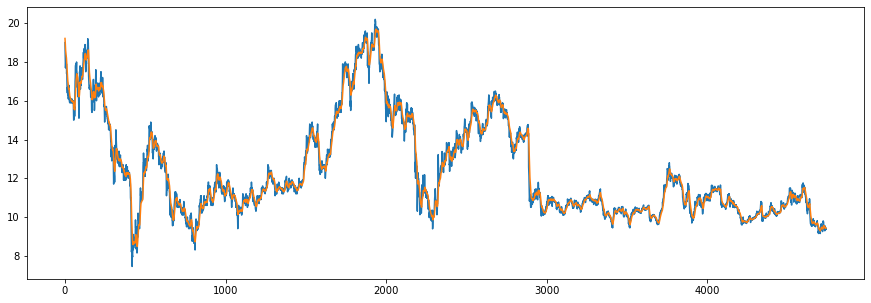

In [10]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/C6L.SI_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
    
X  = np.array(sequential).reshape(-1, 25, 4)
y = labels
y = np.array(y)

In [11]:
from collections import Counter

Counter(y)

Counter({2.0: 4288, 1.0: 213, 0.0: 214})

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('C6L.SI')]
    y = nr_test_data['{}_y'.format('C6L.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('C6L.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('C6L.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'C6L.SI')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'C6L.SI'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'C6L.SI'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('C6L.SI')]
    y = r_test_data['{}_y'.format('C6L.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('C6L.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('C6L.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'C6L.SI')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'C6L.SI'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'C6L.SI'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.352826510721248, 1: 7.396078431372549, 2: 0.3664626445156903}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 2s 56ms/step - loss: 0.2891 - accuracy: 0.5501 - mse: 0.4566 - weighted_accuracy: 0.3225 - weighted_mse: 0.5394 - val_loss: 0.2985 - val_accuracy: 0.0445 - val_mse: 0.3565 - val_weighted_accuracy: 0.0445 - val_weighted_mse: 0.3565
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 0.2118 - accuracy: 0.3834 - mse: 0.8121 - weighted_accuracy: 0.4287 - weighted_mse: 0.8009 - val_loss: 0.2882 - val_accuracy: 0.0456 - val_mse: 0.3829 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.3829
Epoch 3/20
30/30 [==============================] - 1s 25ms/step - loss: 0.1926 - accuracy: 0.3651 - mse: 1.0235 - weighted_accuracy: 0.4739 - weighted_mse: 1.0100 - val_loss: 0.2768 - val_accuracy: 0.0456 - val_mse: 0.4172 - val_weighted_accuracy: 0.0456 - val_weighted_mse: 0.4172
Epoch 4/20
30/30 [==============================] - 1s 

7/7 [==============================] - 0s 10ms/step - loss: 0.1934 - accuracy: 0.2977 - mse: 1.3216 - weighted_accuracy: 0.2977 - weighted_mse: 1.3216


<ipython-input-16-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.1933663785457611
Test accuracy: 0.29767441749572754


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 101
actual holds but predicted sell: 43
actual predicted holds: 54
Percentage buys correct: 5.607476635514018%
Percentage sells correct: 8.51063829787234%
Percentage holds correct: 88.52459016393442%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 45.794392523364486%
Percentage high sells correct: 57.4468085106383%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: -0.6447409640047974%
Share price: $1.0025233714829802
Shares owned at the moment: 0
Cash capital at the moment: $99.08300630859716



<ipython-input-16-a7710c1ac12f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 1s 28ms/step - loss: 0.1488 - accuracy: 0.3767 - mse: 1.4597 - weighted_accuracy: 0.6638 - weighted_mse: 1.3770 - val_loss: 0.1836 - val_accuracy: 0.3754 - val_mse: 1.3196 - val_weighted_accuracy: 0.3754 - val_weighted_mse: 1.3196
Epoch 2/20
30/30 [==============================] - 1s 27ms/step - loss: 0.1481 - accuracy: 0.3486 - mse: 1.4903 - weighted_accuracy: 0.6667 - weighted_mse: 1.3932 - val_loss: 0.1827 - val_accuracy: 0.3828 - val_mse: 1.3661 - val_weighted_accuracy: 0.3828 - val_weighted_mse: 1.3661
Epoch 3/20
30/30 [==============================] - 1s 26ms/step - loss: 0.1463 - accuracy: 0.3836 - mse: 1.4848 - weighted_accuracy: 0.6813 - weighted_mse: 1.4036 - val_loss: 0.1823 - val_accuracy: 0.4072 - val_mse: 1.3409 - val_weighted_accuracy: 0.4072 - val_weighted_mse: 1.3409
Epoch 4/20
30/30 [==============================] - 1s 27ms/step - loss: 0.1456 - accuracy: 0.3849 - mse: 1.4889 - weighted_accuracy: 0.6855 - weighted_mse: 1.406

7/7 [==============================] - 0s 8ms/step - loss: 0.2101 - accuracy: 0.3628 - mse: 1.9138 - weighted_accuracy: 0.3628 - weighted_mse: 1.9138


<ipython-input-16-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.21008427441120148
Test accuracy: 0.36279070377349854


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 78
actual holds but predicted sell: 52
actual predicted holds: 68
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 7.017543859649122%
Percentage holds correct: 91.89189189189189%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 46.42857142857143%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 85.13513513513513%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: -49.54897764427527%
Share price: $0.5090654437174831
Shares owned at the moment: 0
Cash capital at the moment: $50.365015380647094


<ipython-input-16-a7710c1ac12f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 1s 26ms/step - loss: 0.1277 - accuracy: 0.4809 - mse: 1.7878 - weighted_accuracy: 0.7466 - weighted_mse: 1.7161 - val_loss: 0.2002 - val_accuracy: 0.3828 - val_mse: 1.8630 - val_weighted_accuracy: 0.3828 - val_weighted_mse: 1.8630
Epoch 2/20
30/30 [==============================] - 1s 23ms/step - loss: 0.1281 - accuracy: 0.4525 - mse: 1.8130 - weighted_accuracy: 0.7381 - weighted_mse: 1.7322 - val_loss: 0.1787 - val_accuracy: 0.4761 - val_mse: 1.7920 - val_weighted_accuracy: 0.4761 - val_weighted_mse: 1.7920
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.1261 - accuracy: 0.4881 - mse: 1.8139 - weighted_accuracy: 0.7586 - weighted_mse: 1.7437 - val_loss: 0.1755 - val_accuracy: 0.4825 - val_mse: 1.7645 - val_weighted_accuracy: 0.4825 - val_weighted_mse: 1.7645
Epoch 4/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1258 - accuracy: 0.4920 - mse: 1.8137 - weighted_accuracy: 0.7582 - weighted_mse: 1.751

7/7 [==============================] - 0s 11ms/step - loss: 0.2112 - accuracy: 0.4419 - mse: 2.3237 - weighted_accuracy: 0.4419 - weighted_mse: 2.3237


<ipython-input-16-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.21122337877750397
Test accuracy: 0.44186046719551086


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 70
actual holds but predicted sell: 42
actual predicted holds: 86
Percentage buys correct: 7.894736842105263%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 91.48936170212765%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 51.31578947368421%
Percentage high sells correct: 47.72727272727273%
Percentage mid holds correct: 82.97872340425532%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: -49.54897764427527%
Share price: $0.5090654437174831
Shares owned at the moment: 0
Cash capital at the moment: $50.365

<ipython-input-16-a7710c1ac12f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 1s 31ms/step - loss: 0.1094 - accuracy: 0.5862 - mse: 2.1520 - weighted_accuracy: 0.8242 - weighted_mse: 2.1220 - val_loss: 0.1943 - val_accuracy: 0.4486 - val_mse: 2.3438 - val_weighted_accuracy: 0.4486 - val_weighted_mse: 2.3438
Epoch 2/20
30/30 [==============================] - 1s 28ms/step - loss: 0.1096 - accuracy: 0.5639 - mse: 2.1859 - weighted_accuracy: 0.8086 - weighted_mse: 2.1571 - val_loss: 0.1741 - val_accuracy: 0.5398 - val_mse: 2.2870 - val_weighted_accuracy: 0.5398 - val_weighted_mse: 2.2870
Epoch 3/20
30/30 [==============================] - 1s 24ms/step - loss: 0.1081 - accuracy: 0.5923 - mse: 2.1866 - weighted_accuracy: 0.8376 - weighted_mse: 2.1629 - val_loss: 0.1656 - val_accuracy: 0.5811 - val_mse: 2.1997 - val_weighted_accuracy: 0.5811 - val_weighted_mse: 2.1997
Epoch 4/20
30/30 [==============================] - 1s 21ms/step - loss: 0.1078 - accuracy: 0.5941 - mse: 2.2163 - weighted_accuracy: 0.8123 - weighted_mse: 2.212

7/7 [==============================] - 0s 9ms/step - loss: 0.2360 - accuracy: 0.4372 - mse: 2.9083 - weighted_accuracy: 0.4372 - weighted_mse: 2.9083


<ipython-input-16-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.23599115014076233
Test accuracy: 0.4372093081474304


number of predictions: 215
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 70
actual holds but predicted sell: 43
actual predicted holds: 85
Percentage buys correct: 7.894736842105263%
Percentage sells correct: 6.521739130434782%
Percentage holds correct: 91.39784946236558%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 50.0%
Percentage high sells correct: 51.111111111111114%
Percentage mid holds correct: 83.87096774193549%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: -39.91632483099337%
Share price: $0.6062617035671785
Shares owned at the moment: 0
Cash capital at the moment: $59.96098342402286



<ipython-input-16-a7710c1ac12f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 1s 34ms/step - loss: 0.0934 - accuracy: 0.6726 - mse: 2.6606 - weighted_accuracy: 0.8633 - weighted_mse: 2.6903 - val_loss: 0.2024 - val_accuracy: 0.5027 - val_mse: 2.8667 - val_weighted_accuracy: 0.5027 - val_weighted_mse: 2.8667
Epoch 2/20
30/30 [==============================] - 1s 29ms/step - loss: 0.0936 - accuracy: 0.6546 - mse: 2.6842 - weighted_accuracy: 0.8586 - weighted_mse: 2.7097 - val_loss: 0.1740 - val_accuracy: 0.5917 - val_mse: 2.7946 - val_weighted_accuracy: 0.5917 - val_weighted_mse: 2.7946
Epoch 3/20
30/30 [==============================] - 1s 26ms/step - loss: 0.0926 - accuracy: 0.6747 - mse: 2.6911 - weighted_accuracy: 0.8715 - weighted_mse: 2.7214 - val_loss: 0.1666 - val_accuracy: 0.6320 - val_mse: 2.9166 - val_weighted_accuracy: 0.6320 - val_weighted_mse: 2.9166
Epoch 4/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0918 - accuracy: 0.6744 - mse: 2.7451 - weighted_accuracy: 0.8603 - weighted_mse: 2.812

0           -64.1546  


Recession Test


7/7 [==============================] - 0s 9ms/step - loss: 0.2517 - accuracy: 0.4372 - mse: 3.5622 - weighted_accuracy: 0.4372 - weighted_mse: 3.5622


<ipython-input-16-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.25167736411094666
Test accuracy: 0.4372093081474304


number of predictions: 215
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 63
actual holds but predicted sell: 48
actual predicted holds: 87
Percentage buys correct: 5.970149253731344%
Percentage sells correct: 5.882352941176471%
Percentage holds correct: 89.69072164948453%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.76119402985075%
Percentage high sells correct: 46.0%
Percentage mid holds correct: 83.50515463917526%


Capital: 100
Share price: $1.0062617748699323
Shares owned at the moment: 99
Cash capital at the moment: $0.10612951966835737


Price increase from previously bought: -39.91632483099337%
Share price: $0.6062617035671785
Shares owned at the moment: 0
Cash capital at the moment: $59.96098342402286




<ipython-input-16-a7710c1ac12f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 1s 24ms/step - loss: 0.0787 - accuracy: 0.7420 - mse: 3.3081 - weighted_accuracy: 0.8906 - weighted_mse: 3.3848 - val_loss: 0.2021 - val_accuracy: 0.5673 - val_mse: 3.4273 - val_weighted_accuracy: 0.5673 - val_weighted_mse: 3.4273
Epoch 2/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0787 - accuracy: 0.7238 - mse: 3.3107 - weighted_accuracy: 0.8895 - weighted_mse: 3.3800 - val_loss: 0.1820 - val_accuracy: 0.6172 - val_mse: 3.5745 - val_weighted_accuracy: 0.6172 - val_weighted_mse: 3.5745
Epoch 3/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0776 - accuracy: 0.7471 - mse: 3.3541 - weighted_accuracy: 0.8999 - weighted_mse: 3.4313 - val_loss: 0.1758 - val_accuracy: 0.6448 - val_mse: 3.7666 - val_weighted_accuracy: 0.6448 - val_weighted_mse: 3.7666
Epoch 4/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0769 - accuracy: 0.7460 - mse: 3.4066 - weighted_accuracy: 0.8958 - weighted_mse: 3.530

7/7 [==============================] - 0s 6ms/step - loss: 0.2675 - accuracy: 0.5209 - mse: 4.3655 - weighted_accuracy: 0.5209 - weighted_mse: 4.3655
Test loss: 0.2675122320652008
Test accuracy: 0.5209302306175232




<ipython-input-16-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 6
actual holds but predicted buy: 56
actual holds but predicted sell: 34
actual predicted holds: 108
Percentage buys correct: 3.389830508474576%
Percentage sells correct: 5.555555555555555%
Percentage holds correct: 90.0%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.45762711864407%
Percentage high sells correct: 54.285714285714285%
Percentage mid holds correct: 85.0%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price increase from previously bought: -39.124775678263624%
Share price: $0.6062617035671785
Shares owned at the moment: 0
Cash capital at the moment: $60.86857043713846


Share price: $0.4305607551603361
Shares owned at the moment: 140
Cash capita

<ipython-input-16-a7710c1ac12f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['previous_1d'] = df['previous_1d'].shift(-1)
<ipython-input-16-a7710c1ac12f>:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna

30/30 [==============================] - 1s 26ms/step - loss: 0.0655 - accuracy: 0.8028 - mse: 4.1244 - weighted_accuracy: 0.9221 - weighted_mse: 4.2061 - val_loss: 0.2046 - val_accuracy: 0.6098 - val_mse: 4.1490 - val_weighted_accuracy: 0.6098 - val_weighted_mse: 4.1490
Epoch 2/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0654 - accuracy: 0.7869 - mse: 4.1108 - weighted_accuracy: 0.9163 - weighted_mse: 4.1835 - val_loss: 0.1863 - val_accuracy: 0.6797 - val_mse: 4.5736 - val_weighted_accuracy: 0.6797 - val_weighted_mse: 4.5736
Epoch 3/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0646 - accuracy: 0.8043 - mse: 4.1664 - weighted_accuracy: 0.9227 - weighted_mse: 4.2455 - val_loss: 0.1828 - val_accuracy: 0.6914 - val_mse: 4.5261 - val_weighted_accuracy: 0.6914 - val_weighted_mse: 4.5261
Epoch 4/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0637 - accuracy: 0.8020 - mse: 4.2285 - weighted_accuracy: 0.9237 - weighted_mse: 4.345



Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.2790 - accuracy: 0.5953 - mse: 5.5317 - weighted_accuracy: 0.5953 - weighted_mse: 5.5317
Test loss: 0.2789991796016693
Test accuracy: 0.5953488349914551




<ipython-input-16-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 54
actual holds but predicted sell: 21
actual predicted holds: 123
Percentage buys correct: 5.2631578947368425%
Percentage sells correct: 8.695652173913043%
Percentage holds correct: 91.11111111111111%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 49.12280701754386%
Percentage high sells correct: 68.18181818181819%
Percentage mid holds correct: 85.18518518518519%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price increase from previously bought: -39.124775678263624%
Share price: $0.6062617035671785
Shares owned at the moment: 0
Cash capital at the moment: $60.86857043713846


Share price: $0.4473832138878513
Shares owned at t

<ipython-input-16-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.2685703933238983
Test accuracy: 0.6325581669807434


number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 48
actual holds but predicted sell: 19
actual predicted holds: 131
Percentage buys correct: 5.882352941176471%
Percentage sells correct: 9.523809523809524%
Percentage holds correct: 91.60839160839161%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 47.05882352941177%
Percentage high sells correct: 70.0%
Percentage mid holds correct: 85.31468531468532%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price increase from previously bought: -39.124775678263624%
Share price: $0.6062617035671785
Shares owned at the moment: 0
Cash capital at the moment: $60.86857043713846


<ipython-input-16-a7710c1ac12f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['previous_1d'] = df['previous_1d'].shift(-1)
<ipython-input-16-a7710c1ac12f>:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna

30/30 [==============================] - 1s 21ms/step - loss: 0.0463 - accuracy: 0.8735 - mse: 6.2042 - weighted_accuracy: 0.9481 - weighted_mse: 6.0820 - val_loss: 0.2331 - val_accuracy: 0.6681 - val_mse: 5.8947 - val_weighted_accuracy: 0.6681 - val_weighted_mse: 5.8947
Epoch 2/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0451 - accuracy: 0.8659 - mse: 6.1300 - weighted_accuracy: 0.9471 - weighted_mse: 6.0214 - val_loss: 0.2078 - val_accuracy: 0.7582 - val_mse: 7.0117 - val_weighted_accuracy: 0.7582 - val_weighted_mse: 7.0117
Epoch 3/20
30/30 [==============================] - 1s 21ms/step - loss: 0.0446 - accuracy: 0.8733 - mse: 6.2716 - weighted_accuracy: 0.9517 - weighted_mse: 6.1795 - val_loss: 0.2137 - val_accuracy: 0.7508 - val_mse: 7.0382 - val_weighted_accuracy: 0.7508 - val_weighted_mse: 7.0382
Epoch 4/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0453 - accuracy: 0.8666 - mse: 6.3362 - weighted_accuracy: 0.9493 - weighted_mse: 6.285

7/7 [==============================] - 0s 9ms/step - loss: 0.2728 - accuracy: 0.6558 - mse: 7.9465 - weighted_accuracy: 0.6558 - weighted_mse: 7.9465
Test loss: 0.2727757394313812
Test accuracy: 0.6558139324188232




<ipython-input-16-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 45
actual holds but predicted sell: 17
actual predicted holds: 136
Percentage buys correct: 6.25%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 91.89189189189189%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 43.75%
Percentage high sells correct: 77.77777777777777%
Percentage mid holds correct: 85.8108108108108%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price increase from previously bought: -39.124775678263624%
Share price: $0.6062617035671785
Shares owned at the moment: 0
Cash capital at the moment: $60.86857043713846


Share price: $0.4473832138878513
Shares owned at the moment: 135
Cash capita

<ipython-input-16-a7710c1ac12f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 1s 22ms/step - loss: 0.0403 - accuracy: 0.8955 - mse: 7.4624 - weighted_accuracy: 0.9543 - weighted_mse: 7.1634 - val_loss: 0.2426 - val_accuracy: 0.7052 - val_mse: 7.3006 - val_weighted_accuracy: 0.7052 - val_weighted_mse: 7.3006
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0390 - accuracy: 0.8892 - mse: 7.3219 - weighted_accuracy: 0.9557 - weighted_mse: 7.0530 - val_loss: 0.2310 - val_accuracy: 0.7593 - val_mse: 8.3197 - val_weighted_accuracy: 0.7593 - val_weighted_mse: 8.3197
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.0390 - accuracy: 0.8945 - mse: 7.4664 - weighted_accuracy: 0.9613 - weighted_mse: 7.2057 - val_loss: 0.2369 - val_accuracy: 0.7423 - val_mse: 8.0200 - val_weighted_accuracy: 0.7423 - val_weighted_mse: 8.0200
Epoch 4/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0389 - accuracy: 0.8905 - mse: 7.5665 - weighted_accuracy: 0.9561 - weighted_mse: 7.314

7/7 [==============================] - 0s 6ms/step - loss: 0.2922 - accuracy: 0.6651 - mse: 9.6655 - weighted_accuracy: 0.6651 - weighted_mse: 9.6655
Test loss: 0.29224658012390137
Test accuracy: 0.6651162505149841




<ipython-input-16-a7710c1ac12f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-16-a7710c1ac12f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 45
actual holds but predicted sell: 14
actual predicted holds: 139
Percentage buys correct: 4.25531914893617%
Percentage sells correct: 12.5%
Percentage holds correct: 91.44736842105263%
actual buys: 8
actual sells: 9
actual holds: 198


Percentage low buys correct: 42.5531914893617%
Percentage high sells correct: 75.0%
Percentage mid holds correct: 84.10596026490066%


Capital: 100
Share price: $0.9931775412724846
Shares owned at the moment: 100
Cash capital at the moment: $0.40912204890159387


Price increase from previously bought: -80.0398292528904%
Share price: $0.19878509287584767
Shares owned at the moment: 0
Cash capital at the moment: $20.232965435945502


Share price: $0.09224300281565666
Shares owned at the moment: 218
Cash capital 

<ipython-input-16-a7710c1ac12f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-16-a7710c1ac12f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['previous_1d'] = df['previous_1d'].shift(-1)
<ipython-input-16-a7710c1ac12f>:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna

In [17]:
df = nr_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.307339,6.481481,8.163265,91.803279,54.629630,57.142857,76.666667,-58.208516,-64.1546
1,0.353211,7.692308,7.407407,90.410959,52.747253,51.851852,80.555556,-14.986217,-64.1546
2,0.449541,8.695652,5.882353,90.816327,50.724638,50.980392,81.443299,-65.716201,-64.1546
3,0.490826,9.677419,6.122449,91.588785,58.064516,51.020408,80.188679,-56.118590,-64.1546
4,0.504587,8.620690,6.250000,91.071429,56.896552,52.083333,80.180180,-48.180030,-64.1546
5,0.536697,8.771930,9.090909,92.307692,57.894737,56.818182,80.172414,-49.486068,-64.1546
6,0.591743,9.259259,9.090909,92.366412,57.407407,54.545455,80.769231,-49.316648,-64.1546
7,0.660550,10.256410,12.121212,93.150685,64.102564,63.636364,82.758621,47.019890,-64.1546
8,0.678899,11.111111,7.142857,92.207792,63.888889,64.285714,81.699346,-24.913994,-64.1546
9,0.701835,12.121212,7.692308,92.452830,66.666667,65.384615,81.012658,-31.143140,-64.1546


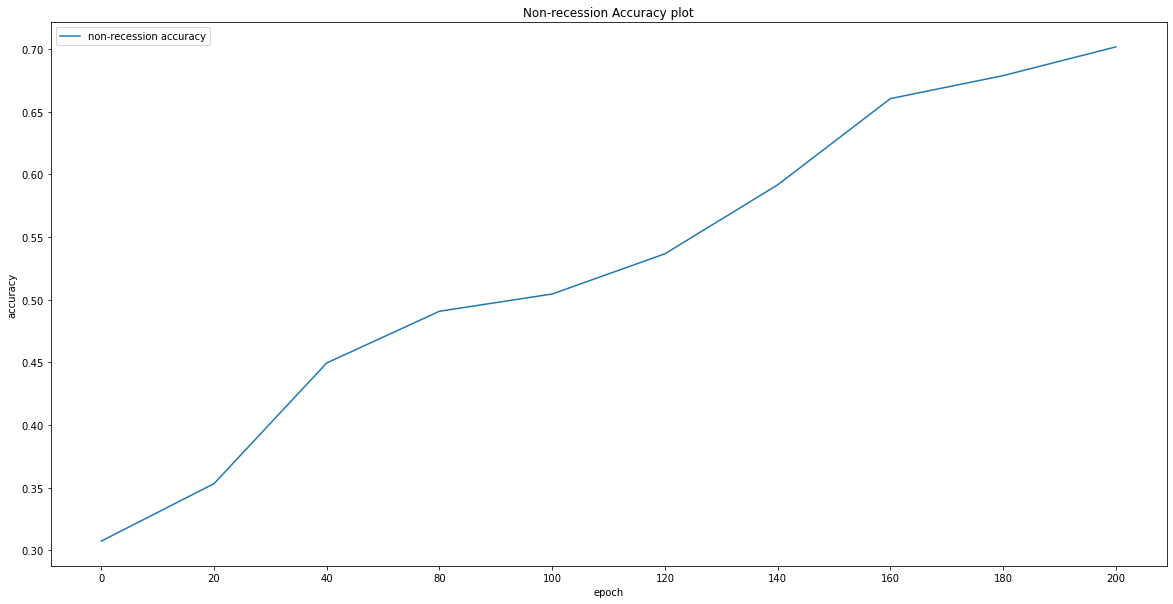

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

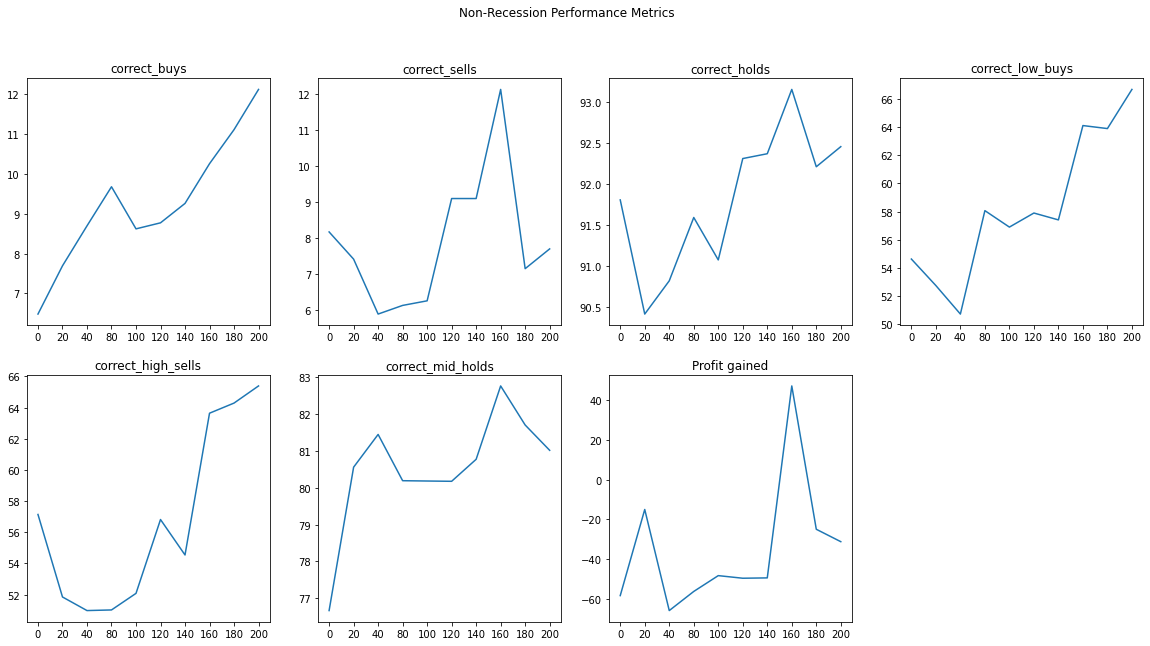

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

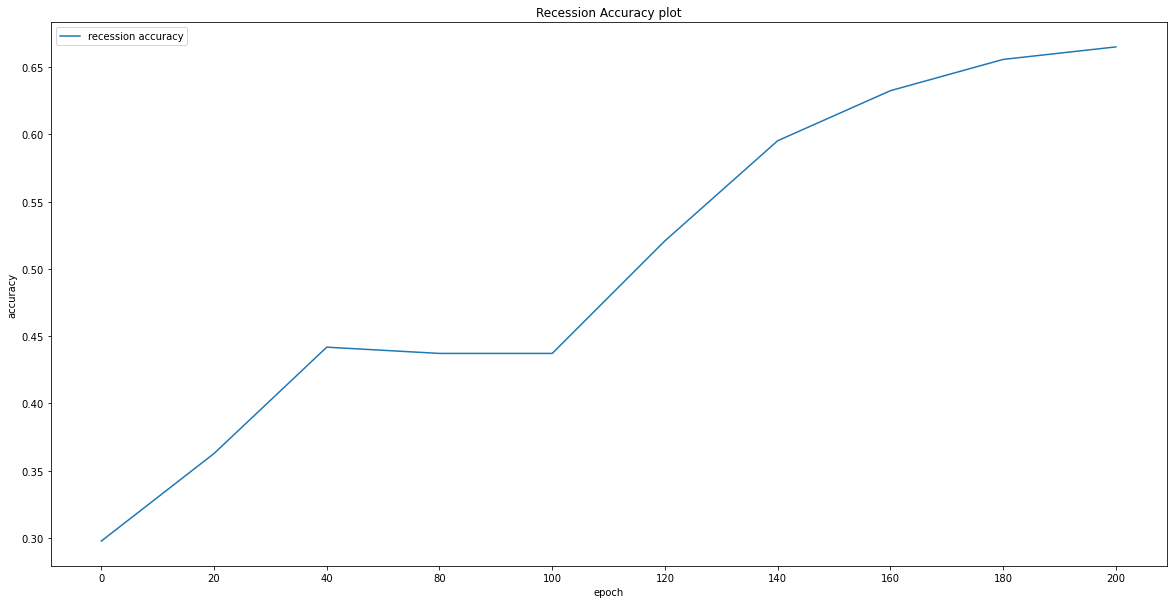

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

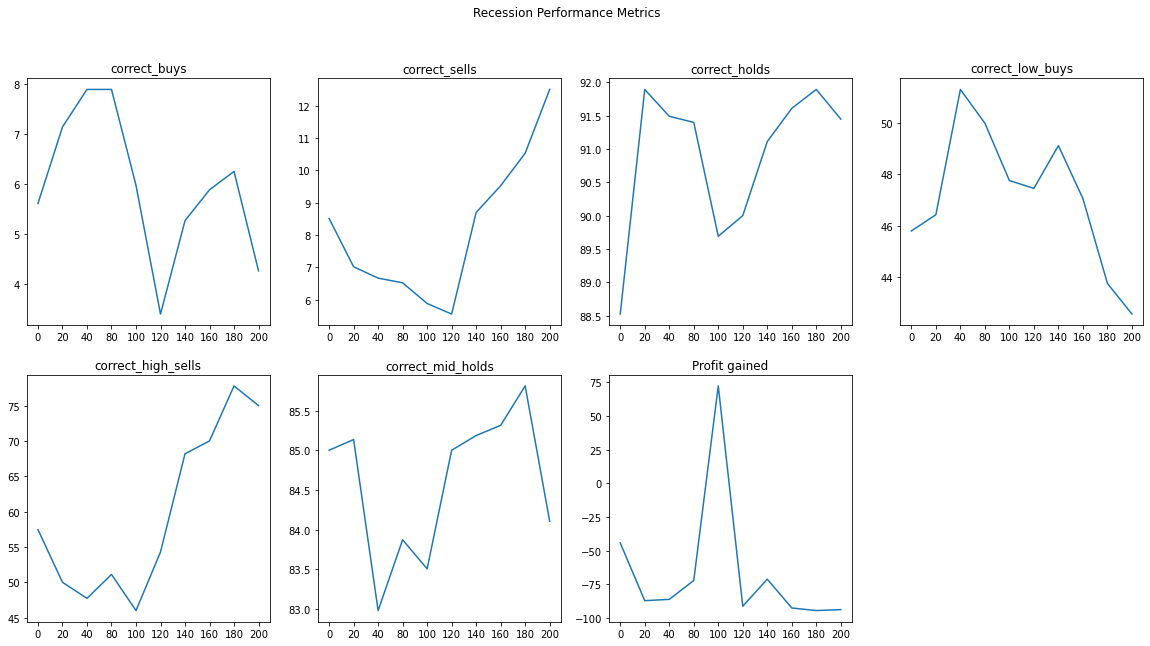

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### OCBC Bank

In [22]:
nr_test_sets = ['O39.SI']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1
        
    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-12-07        11.31  11.282011 -31.958699  451430629.0     2.0
2018-12-10        11.23  11.274010 -40.206210  447140929.0     2.0
2018-12-11        11.07  11.242623 -56.701035  443372229.0     1.0
2018-12-12        11.05  11.212989 -65.517215  438680229.0     2.0
2018-12-13        11.20  11.210991 -48.275877  443121729.0     2.0


In [23]:
r_test_sets = ['O39.SI']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1
    

    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-12-09        10.71  10.802927 -75.438564  46900142.0     2.0
2019-12-10        10.64  10.777861 -87.272614  42802742.0     1.0
2019-12-11        10.62  10.753575 -90.196045  37577242.0     2.0
2019-12-12        10.68  10.742256 -78.431263  41151442.0     2.0
2019-12-13        10.85  10.758832 -45.097929  47717842.0     2.0


### training Data

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


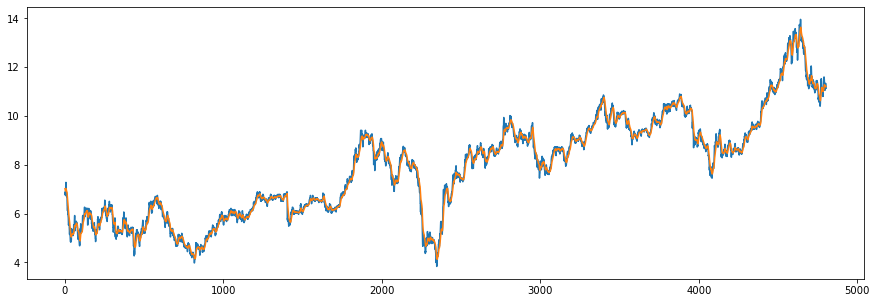

In [24]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/O39.SI_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1   
    
X  = np.array(sequential).reshape(-1, 25, 4)
y = labels
y = np.array(y)

In [25]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [26]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [27]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [29]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('O39.SI')]
    y = nr_test_data['{}_y'.format('O39.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('O39.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('O39.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'O39.SI')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'O39.SI'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'O39.SI'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('O39.SI')]
    y = r_test_data['{}_y'.format('O39.SI')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('O39.SI'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('O39.SI'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'O39.SI')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'O39.SI'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'O39.SI'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.240530303030303, 1: 7.915113871635611, 2: 0.36555746796710653}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 43ms/step - loss: 0.2835 - accuracy: 0.5773 - mse: 0.4423 - weighted_accuracy: 0.3431 - weighted_mse: 0.5343 - val_loss: 0.2988 - val_accuracy: 0.0418 - val_mse: 0.3554 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3554
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.2104 - accuracy: 0.3604 - mse: 0.7926 - weighted_accuracy: 0.4181 - weighted_mse: 0.7836 - val_loss: 0.2894 - val_accuracy: 0.0418 - val_mse: 0.3837 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3837
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1900 - accuracy: 0.3272 - mse: 1.0256 - weighted_accuracy: 0.4932 - weighted_mse: 1.0024 - val_loss: 0.2792 - val_accuracy: 0.0418 - val_mse: 0.4215 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.4215
Epoch 4/20
30/30 [==============================] - 0s

7/7 [==============================] - 0s 5ms/step - loss: 0.1685 - accuracy: 0.4837 - mse: 1.2800 - weighted_accuracy: 0.4837 - weighted_mse: 1.2800


<ipython-input-29-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.16852381825447083
Test accuracy: 0.48372092843055725


number of predictions: 215
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 49
actual holds but predicted sell: 48
actual predicted holds: 96
Percentage buys correct: 9.25925925925926%
Percentage sells correct: 5.769230769230769%
Percentage holds correct: 88.07339449541284%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 61.111111111111114%
Percentage high sells correct: 47.05882352941177%
Percentage mid holds correct: 84.40366972477064%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Price increase from previously bought: -73.05079802619241%
Share price: $0.2630488864181231
Shares owned at the moment: 0
Cash capital at the moment: $27.1

Epoch 19/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1285 - accuracy: 0.4745 - mse: 1.8163 - weighted_accuracy: 0.7482 - weighted_mse: 1.7565 - val_loss: 0.1810 - val_accuracy: 0.4508 - val_mse: 1.8857 - val_weighted_accuracy: 0.4508 - val_weighted_mse: 1.8857
Epoch 20/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1282 - accuracy: 0.4619 - mse: 1.8414 - weighted_accuracy: 0.7418 - weighted_mse: 1.7653 - val_loss: 0.1886 - val_accuracy: 0.4205 - val_mse: 1.8568 - val_weighted_accuracy: 0.4205 - val_weighted_mse: 1.8568
Validation loss: 0.18855464458465576
Validation accuracy: 0.42050209641456604


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1895 - accuracy: 0.3761 - mse: 1.9432 - weighted_accuracy: 0.3761 - weighted_mse: 1.9432
Test loss: 0.18954287469387054
Test accuracy: 0.3761467933654785


number of predictions: 218
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted ho

<ipython-input-29-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 62
actual holds but predicted sell: 28
actual predicted holds: 103
Percentage buys correct: 7.462686567164179%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 89.56521739130434%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 62.6865671641791%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 85.96491228070175%


Capital: 100
Share price: $0.9581707117622773
Shares owned at the moment: 104
Cash capital at the moment: $0.0762091531591409


Price increase from previously bought: -77.38179406913402%
Share price: $0.2173170075737143
Shares owned at the moment: 0
Cash capital at the moment: $22.61502527665935


Share price: $0.26609744573760596
Shares owned at th

<ipython-input-29-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 47
actual holds but predicted sell: 22
actual predicted holds: 124
Percentage buys correct: 6.0%
Percentage sells correct: 8.0%
Percentage holds correct: 88.57142857142857%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 58.0%
Percentage high sells correct: 56.0%
Percentage mid holds correct: 83.45323741007195%


Capital: 100
Share price: $0.9581707117622773
Shares owned at the moment: 104
Cash capital at the moment: $0.0762091531591409


Price increase from previously bought: -77.38179406913402%
Share price: $0.2173170075737143
Shares owned at the moment: 0
Cash capital at the moment: $22.61502527665935


Share price: $0.26609744573760596
Shares owned at the moment: 84
Cash capital at the moment: $0.201371324

<ipython-input-29-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 46
actual holds but predicted sell: 16
actual predicted holds: 131
Percentage buys correct: 4.166666666666667%
Percentage sells correct: 10.526315789473685%
Percentage holds correct: 88.51351351351352%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 62.5%
Percentage high sells correct: 47.36842105263158%
Percentage mid holds correct: 84.35374149659864%


Capital: 100
Share price: $0.9581707117622773
Shares owned at the moment: 104
Cash capital at the moment: $0.0762091531591409


Price increase from previously bought: -72.93937354593334%
Share price: $0.2600000363442929
Shares owned at the moment: 0
Cash capital at the moment: $27.041852922571135


Share price: $0.26609744573760596
Shares owned at the moment: 

<ipython-input-29-6014b972f16f>:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


30/30 [==============================] - 0s 14ms/step - loss: 0.0954 - accuracy: 0.6668 - mse: 2.6772 - weighted_accuracy: 0.8501 - weighted_mse: 2.7019 - val_loss: 0.1724 - val_accuracy: 0.5805 - val_mse: 2.7589 - val_weighted_accuracy: 0.5805 - val_weighted_mse: 2.7589
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0958 - accuracy: 0.6432 - mse: 2.6812 - weighted_accuracy: 0.8412 - weighted_mse: 2.6906 - val_loss: 0.1680 - val_accuracy: 0.5941 - val_mse: 2.8327 - val_weighted_accuracy: 0.5941 - val_weighted_mse: 2.8327
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0943 - accuracy: 0.6539 - mse: 2.7235 - weighted_accuracy: 0.8435 - weighted_mse: 2.7135 - val_loss: 0.1850 - val_accuracy: 0.5753 - val_mse: 3.0921 - val_weighted_accuracy: 0.5753 - val_weighted_mse: 3.0921
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0929 - accuracy: 0.6696 - mse: 2.7564 - weighted_accuracy: 0.8496 - weighted_mse: 2.775

7/7 [==============================] - 0s 5ms/step - loss: 0.1843 - accuracy: 0.6791 - mse: 3.8195 - weighted_accuracy: 0.6791 - weighted_mse: 3.8195


<ipython-input-29-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.18426889181137085
Test accuracy: 0.6790697574615479


number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 29
actual holds but predicted sell: 20
actual predicted holds: 144
Percentage buys correct: 3.3333333333333335%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 88.34355828220859%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 56.666666666666664%
Percentage high sells correct: 36.36363636363637%
Percentage mid holds correct: 84.5679012345679%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Price increase from previously bought: -3.7100678942233567%
Share price: $0.9398779020736454
Shares owned at the moment: 0
Cash capital at the moment: $9

<ipython-input-29-6014b972f16f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['previous_1d'] = df['previous_1d'].shift(-1)
<ipython-input-29-6014b972f16f>:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna

30/30 [==============================] - 0s 16ms/step - loss: 0.0818 - accuracy: 0.7235 - mse: 3.2973 - weighted_accuracy: 0.8802 - weighted_mse: 3.3086 - val_loss: 0.1673 - val_accuracy: 0.6391 - val_mse: 3.4439 - val_weighted_accuracy: 0.6391 - val_weighted_mse: 3.4439
Epoch 2/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0827 - accuracy: 0.7089 - mse: 3.2806 - weighted_accuracy: 0.8673 - weighted_mse: 3.2968 - val_loss: 0.1714 - val_accuracy: 0.6360 - val_mse: 3.5804 - val_weighted_accuracy: 0.6360 - val_weighted_mse: 3.5804
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0812 - accuracy: 0.7157 - mse: 3.3492 - weighted_accuracy: 0.8813 - weighted_mse: 3.3237 - val_loss: 0.1830 - val_accuracy: 0.6203 - val_mse: 3.6073 - val_weighted_accuracy: 0.6203 - val_weighted_mse: 3.6073
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.0801 - accuracy: 0.7256 - mse: 3.4029 - weighted_accuracy: 0.8848 - weighted_mse: 3.402

7/7 [==============================] - 0s 4ms/step - loss: 0.2057 - accuracy: 0.6884 - mse: 4.9807 - weighted_accuracy: 0.6884 - weighted_mse: 4.9807


<ipython-input-29-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.2057388871908188
Test accuracy: 0.6883720755577087


number of predictions: 215
actual predicted buys: 1
actual buys but predicted sell: 1
actual buys but predicted hold: 10
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 27
actual holds but predicted sell: 20
actual predicted holds: 146
Percentage buys correct: 3.5714285714285716%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 88.48484848484848%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 67.85714285714286%
Percentage high sells correct: 40.90909090909091%
Percentage mid holds correct: 84.14634146341463%


Capital: 100
Share price: $0.9581707117622773
Shares owned at the moment: 104
Cash capital at the moment: $0.0762091531591409


Price increase from previously bought: -2.1781489800739906%
Share price: $0.9398779020736454
Shares owned at the moment: 0
Cash capital at the moment: $97

<ipython-input-29-6014b972f16f>:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


30/30 [==============================] - 0s 12ms/step - loss: 0.0697 - accuracy: 0.7690 - mse: 4.1064 - weighted_accuracy: 0.9060 - weighted_mse: 4.0422 - val_loss: 0.1700 - val_accuracy: 0.6778 - val_mse: 4.2397 - val_weighted_accuracy: 0.6778 - val_weighted_mse: 4.2397
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0716 - accuracy: 0.7573 - mse: 4.0555 - weighted_accuracy: 0.8962 - weighted_mse: 3.9928 - val_loss: 0.1698 - val_accuracy: 0.6893 - val_mse: 4.4660 - val_weighted_accuracy: 0.6893 - val_weighted_mse: 4.4660
Epoch 3/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0690 - accuracy: 0.7688 - mse: 4.1320 - weighted_accuracy: 0.9083 - weighted_mse: 4.0181 - val_loss: 0.1866 - val_accuracy: 0.6632 - val_mse: 4.4592 - val_weighted_accuracy: 0.6632 - val_weighted_mse: 4.4592
Epoch 4/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0690 - accuracy: 0.7716 - mse: 4.2236 - weighted_accuracy: 0.9072 - weighted_mse: 4.138

7/7 [==============================] - 0s 7ms/step - loss: 0.2428 - accuracy: 0.6884 - mse: 6.3586 - weighted_accuracy: 0.6884 - weighted_mse: 6.3586


<ipython-input-29-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.24283626675605774
Test accuracy: 0.6883720755577087


number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 28
actual holds but predicted sell: 20
actual predicted holds: 145
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 4.545454545454546%
Percentage holds correct: 88.95705521472392%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 63.333333333333336%
Percentage high sells correct: 40.90909090909091%
Percentage mid holds correct: 85.18518518518519%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Price increase from previously bought: -3.7100678942233567%
Share price: $0.9398779020736454
Shares owned at the moment: 0
Cash capital at the moment: $96

<ipython-input-29-6014b972f16f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-6014b972f16f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 1s 19ms/step - loss: 0.0599 - accuracy: 0.8080 - mse: 5.1071 - weighted_accuracy: 0.9221 - weighted_mse: 4.9143 - val_loss: 0.1736 - val_accuracy: 0.7144 - val_mse: 5.3053 - val_weighted_accuracy: 0.7144 - val_weighted_mse: 5.3053
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.0611 - accuracy: 0.8017 - mse: 5.0339 - weighted_accuracy: 0.9180 - weighted_mse: 4.8425 - val_loss: 0.1792 - val_accuracy: 0.7207 - val_mse: 5.5181 - val_weighted_accuracy: 0.7207 - val_weighted_mse: 5.5181
Epoch 3/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0585 - accuracy: 0.8104 - mse: 5.0756 - weighted_accuracy: 0.9253 - weighted_mse: 4.8211 - val_loss: 0.1870 - val_accuracy: 0.7155 - val_mse: 5.3258 - val_weighted_accuracy: 0.7155 - val_weighted_mse: 5.3258
Epoch 4/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0594 - accuracy: 0.8127 - mse: 5.2237 - weighted_accuracy: 0.9202 - weighted_mse: 4.967

7/7 [==============================] - 0s 6ms/step - loss: 0.2745 - accuracy: 0.7070 - mse: 7.9266 - weighted_accuracy: 0.7070 - weighted_mse: 7.9266
Test loss: 0.2745225727558136
Test accuracy: 0.7069767713546753




<ipython-input-29-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 27
actual holds but predicted sell: 17
actual predicted holds: 149
Percentage buys correct: 6.666666666666667%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 89.75903614457832%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 63.333333333333336%
Percentage high sells correct: 36.8421052631579%
Percentage mid holds correct: 86.06060606060606%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Price increase from previously bought: -73.36315090305237%
Share price: $0.2600000363442929
Shares owned at the moment: 0
Cash capital at the moment: $26.885734401139832


Share price: $0.2813414053524099
Shares owned at 

<ipython-input-29-6014b972f16f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-6014b972f16f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 1s 24ms/step - loss: 0.0509 - accuracy: 0.8438 - mse: 6.1668 - weighted_accuracy: 0.9354 - weighted_mse: 5.7787 - val_loss: 0.1813 - val_accuracy: 0.7552 - val_mse: 6.5076 - val_weighted_accuracy: 0.7552 - val_weighted_mse: 6.5076
Epoch 2/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0530 - accuracy: 0.8352 - mse: 6.0861 - weighted_accuracy: 0.9344 - weighted_mse: 5.6938 - val_loss: 0.1873 - val_accuracy: 0.7458 - val_mse: 6.8463 - val_weighted_accuracy: 0.7458 - val_weighted_mse: 6.8463
Epoch 3/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0503 - accuracy: 0.8467 - mse: 6.1394 - weighted_accuracy: 0.9422 - weighted_mse: 5.6678 - val_loss: 0.1979 - val_accuracy: 0.7448 - val_mse: 6.4871 - val_weighted_accuracy: 0.7448 - val_weighted_mse: 6.4871
Epoch 4/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0501 - accuracy: 0.8522 - mse: 6.3536 - weighted_accuracy: 0.9384 - weighted_mse: 5.858

7/7 [==============================] - 0s 7ms/step - loss: 0.3104 - accuracy: 0.7070 - mse: 9.8744 - weighted_accuracy: 0.7070 - weighted_mse: 9.8744


<ipython-input-29-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.31035614013671875
Test accuracy: 0.7069767713546753


number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 28
actual holds but predicted sell: 16
actual predicted holds: 149
Percentage buys correct: 6.451612903225806%
Percentage sells correct: 5.555555555555555%
Percentage holds correct: 89.75903614457832%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 61.29032258064516%
Percentage high sells correct: 33.333333333333336%
Percentage mid holds correct: 86.06060606060606%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Price increase from previously bought: -73.36315090305237%
Share price: $0.2600000363442929
Shares owned at the moment: 0
Cash capital at the moment: $26.

<ipython-input-29-6014b972f16f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-6014b972f16f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 1s 25ms/step - loss: 0.0429 - accuracy: 0.8758 - mse: 7.4772 - weighted_accuracy: 0.9488 - weighted_mse: 6.7939 - val_loss: 0.2001 - val_accuracy: 0.7709 - val_mse: 7.8530 - val_weighted_accuracy: 0.7709 - val_weighted_mse: 7.8530
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0458 - accuracy: 0.8556 - mse: 7.3362 - weighted_accuracy: 0.9379 - weighted_mse: 6.6667 - val_loss: 0.2030 - val_accuracy: 0.7720 - val_mse: 8.4333 - val_weighted_accuracy: 0.7720 - val_weighted_mse: 8.4333
Epoch 3/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0426 - accuracy: 0.8742 - mse: 7.4099 - weighted_accuracy: 0.9522 - weighted_mse: 6.6639 - val_loss: 0.2198 - val_accuracy: 0.7448 - val_mse: 7.8019 - val_weighted_accuracy: 0.7448 - val_weighted_mse: 7.8019
Epoch 4/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0434 - accuracy: 0.8760 - mse: 7.6790 - weighted_accuracy: 0.9471 - weighted_mse: 6.903

7/7 [==============================] - 0s 11ms/step - loss: 0.3381 - accuracy: 0.7256 - mse: 11.8084 - weighted_accuracy: 0.7256 - weighted_mse: 11.8084


<ipython-input-29-6014b972f16f>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-6014b972f16f>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.3380536139011383
Test accuracy: 0.7255814075469971


number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 1
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 26
actual holds but predicted sell: 14
actual predicted holds: 153
Percentage buys correct: 6.896551724137931%
Percentage sells correct: 6.25%
Percentage holds correct: 90.0%
actual buys: 12
actual sells: 10
actual holds: 193


Percentage low buys correct: 65.51724137931035%
Percentage high sells correct: 37.5%
Percentage mid holds correct: 86.3905325443787%


Capital: 100
Share price: $0.9734146713770804
Shares owned at the moment: 102
Cash capital at the moment: $0.4386607042165309


Price increase from previously bought: -73.36315090305237%
Share price: $0.2600000363442929
Shares owned at the moment: 0
Cash capital at the moment: $26.885734401139832


Share price: $0.28134140

<ipython-input-29-6014b972f16f>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-29-6014b972f16f>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-29-6014b972f16f>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [30]:
df = r_log_hist['epochs_logs']
df.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.483721,9.259259,5.769231,88.073394,61.111111,47.058824,84.403670,-14.395524,-24.56292
1,0.516279,7.462687,9.090909,89.565217,62.686567,54.545455,85.964912,-28.535842,-24.56292
2,0.600000,6.000000,8.000000,88.571429,58.000000,56.000000,83.453237,-49.156503,-24.56292
3,0.627907,4.166667,10.526316,88.513514,62.500000,47.368421,84.353741,10.752255,-24.56292
4,0.679070,3.333333,4.545455,88.343558,56.666667,36.363636,84.567901,400.689985,-24.56292
5,0.688372,3.571429,4.545455,88.484848,67.857143,40.909091,84.146341,520.059855,-24.56292
6,0.688372,6.666667,4.545455,88.957055,63.333333,40.909091,85.185185,262.460640,-24.56292
7,0.706977,6.666667,5.263158,89.759036,63.333333,36.842105,86.060606,-12.895099,-24.56292
8,0.706977,6.451613,5.555556,89.759036,61.290323,33.333333,86.060606,-26.849119,-24.56292
9,0.725581,6.896552,6.250000,90.000000,65.517241,37.500000,86.390533,-26.849119,-24.56292


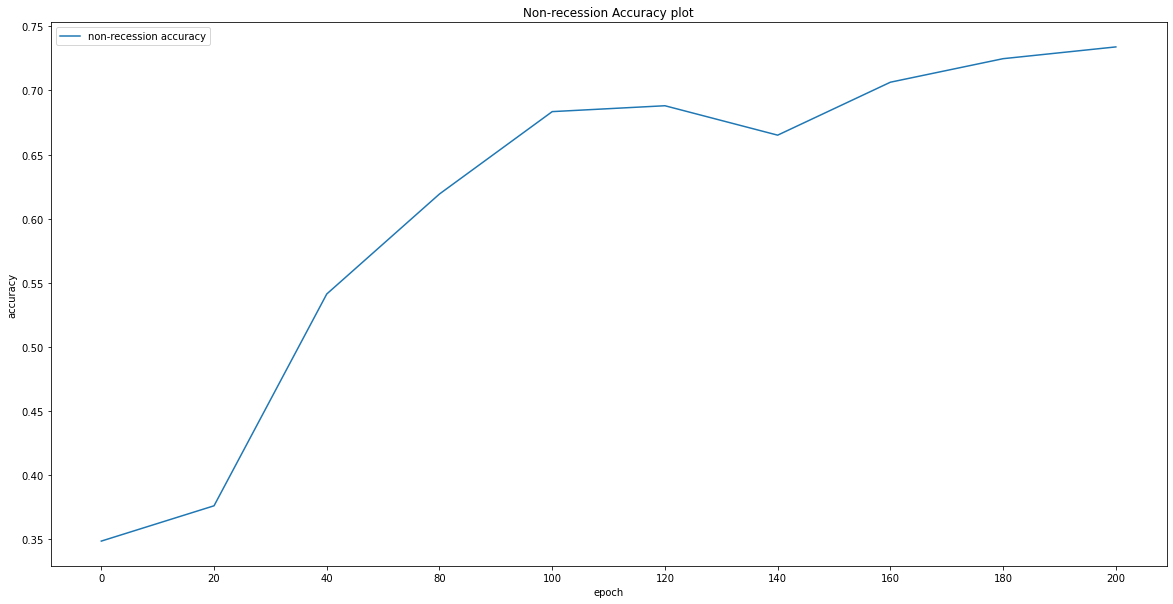

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

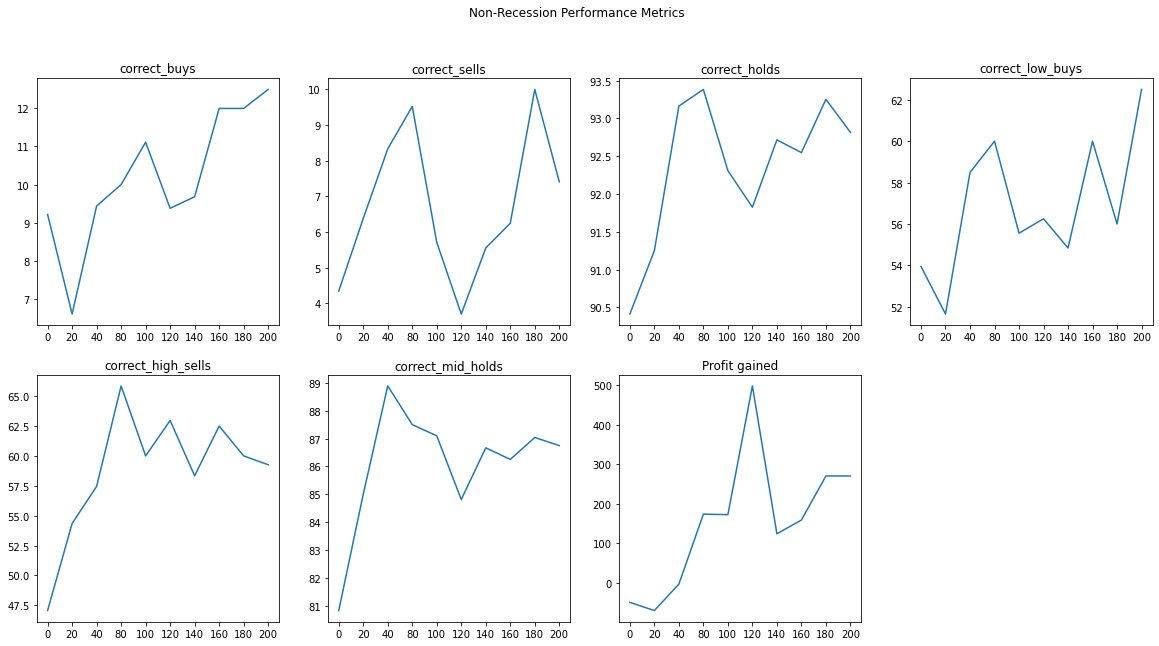

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

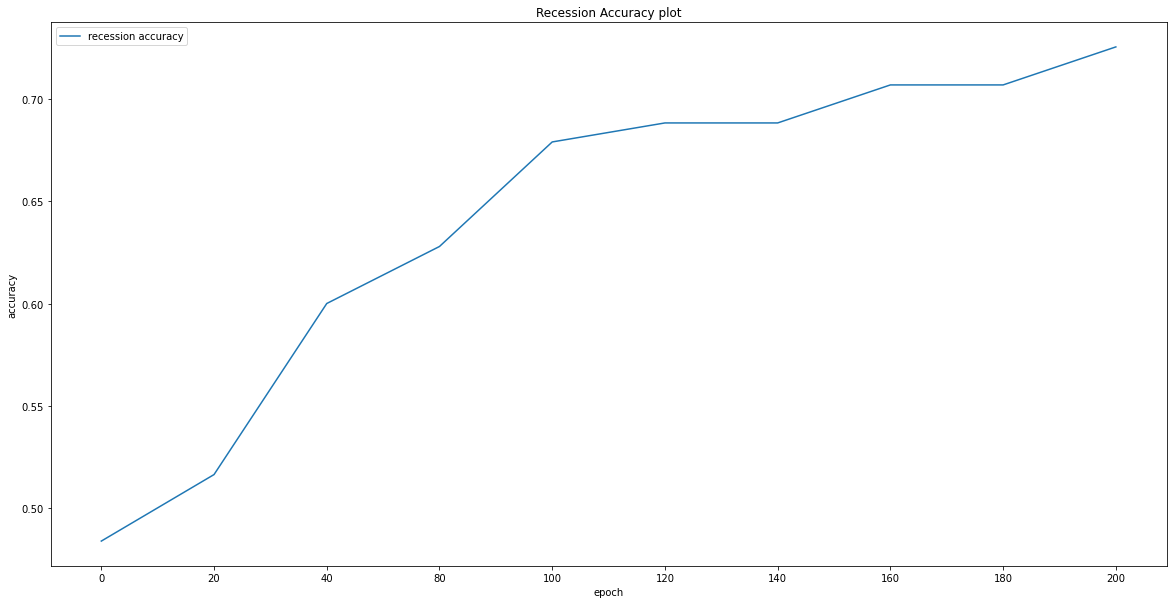

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

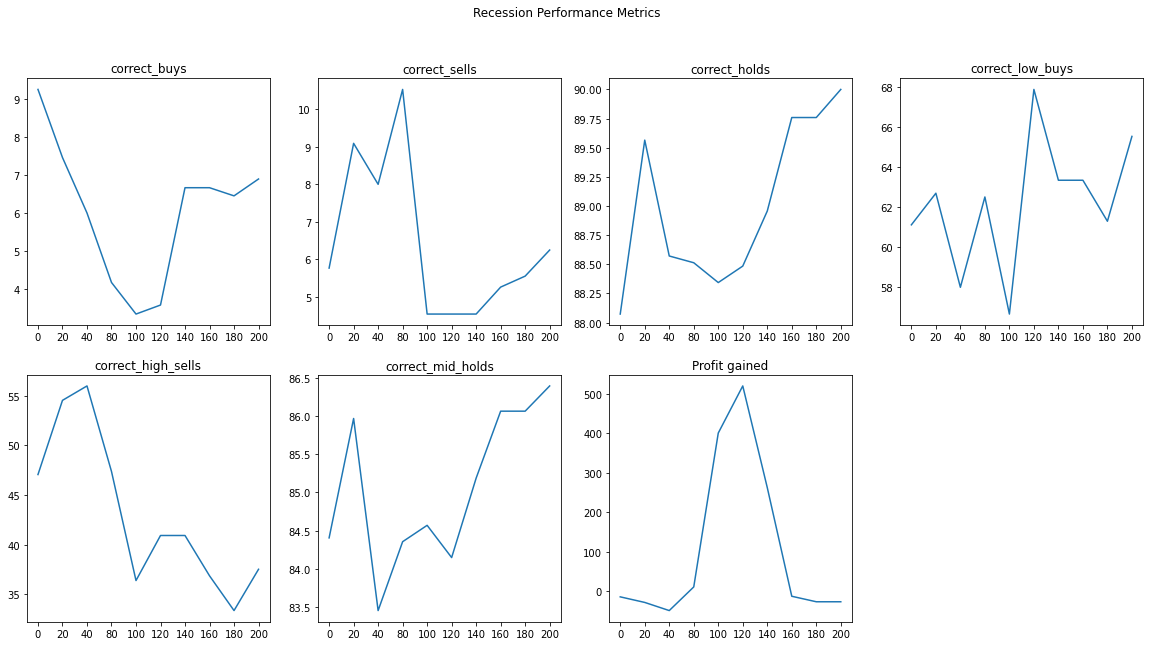

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### CNOOC Limited

In [15]:
nr_test_sets = ['0883.HK']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1
    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14         OBV_7  labels
Date                                                               
2018-12-05        13.84  13.206983 -13.953473  9.687209e+09     2.0
2018-12-06        13.32  13.224370 -44.186053  9.629185e+09     2.0
2018-12-07        13.06  13.199082 -59.302288  9.569866e+09     2.0
2018-12-10        12.78  13.134608 -75.581395  9.417195e+09     2.0
2018-12-11        12.82  13.086207 -73.255816  9.502415e+09     2.0


In [16]:
r_test_sets = ['0883.HK']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1
     
        
    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-12-05        11.16  11.619972 -96.000004 -309527686.0     2.0
2019-12-06        11.30  11.570745 -81.249969 -265649189.0     2.0
2019-12-09        11.30  11.529092 -81.249969 -265649189.0     2.0
2019-12-10        11.32  11.496924 -79.166687 -219481840.0     2.0
2019-12-11        11.28  11.463551 -83.333350 -262942881.0     2.0


### Training Data

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


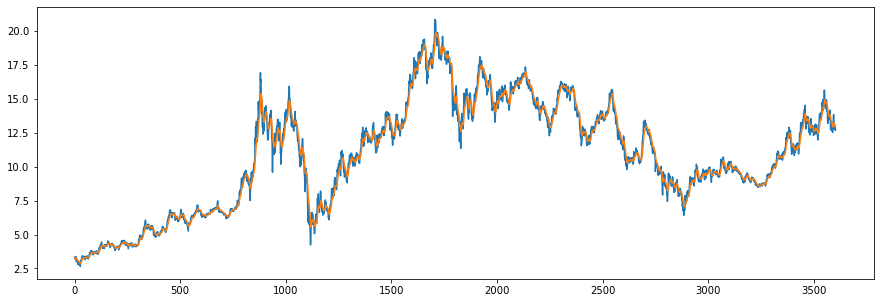

In [17]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/0883.HK_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

    
X  = np.array(sequential).reshape(-1, 25, 4)
y = labels
y = np.array(y)

In [18]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [19]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [20]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [45]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [46]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('0883.HK')]
    y = nr_test_data['{}_y'.format('0883.HK')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('0883.HK'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('0883.HK'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'0883.HK')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'0883.HK'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'0883.HK'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('0883.HK')]
    y = r_test_data['{}_y'.format('0883.HK')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('0883.HK'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('0883.HK'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'0883.HK')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'0883.HK'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'0883.HK'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 1 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.232323232323233, 1: 7.343589743589743, 2: 0.3668972585190879}



RUNNING EPOCHS 0 - 20



Epoch 1/20
23/23 [==============================] - 2s 68ms/step - loss: 0.2917 - accuracy: 0.5457 - mse: 0.4210 - weighted_accuracy: 0.3433 - weighted_mse: 0.5041 - val_loss: 0.3016 - val_accuracy: 0.0489 - val_mse: 0.3512 - val_weighted_accuracy: 0.0489 - val_weighted_mse: 0.3512
Epoch 2/20
23/23 [==============================] - 0s 16ms/step - loss: 0.2171 - accuracy: 0.4145 - mse: 0.7009 - weighted_accuracy: 0.4160 - weighted_mse: 0.7039 - val_loss: 0.2935 - val_accuracy: 0.0447 - val_mse: 0.3718 - val_weighted_accuracy: 0.0447 - val_weighted_mse: 0.3718
Epoch 3/20
23/23 [==============================] - 0s 16ms/step - loss: 0.1963 - accuracy: 0.3568 - mse: 0.9242 - weighted_accuracy: 0.4450 - weighted_mse: 0.9084 - val_loss: 0.2859 - val_accuracy: 0.0447 - val_mse: 0.3992 - val_weighted_accuracy: 0.0447 - val_weighted_mse: 0.3992
Epoch 4/20
23/23 [==============================] - 0s 

<ipython-input-46-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-46-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-46-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.20586033165454865
Test accuracy: 0.2582159638404846


number of predictions: 213
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 5
actual predicted sells: 1
actual sells but predicted hold: 4
actual holds but predicted buy: 140
actual holds but predicted sell: 5
actual predicted holds: 48
Percentage buys correct: 3.9735099337748343%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 85.71428571428571%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 40.0%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 76.78571428571429%


Capital: 100
Share price: $1.01
Shares owned at the moment: 98
Cash capital at the moment: $0.7478049999999996


Price increase from previously bought: -66.43228617004485%
Share price: $0.33996625293417404
Shares owned at the moment: 0
Cash capital at the moment: $33.9728768823833


Share price: $0.32481487

<ipython-input-46-20584ff8f47e>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-46-20584ff8f47e>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['previous_1d'] = df['previous_1d'].shift(-1)
<ipython-input-46-20584ff8f47e>:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna

23/23 [==============================] - 0s 17ms/step - loss: 0.1485 - accuracy: 0.3582 - mse: 1.4295 - weighted_accuracy: 0.6752 - weighted_mse: 1.3557 - val_loss: 0.1970 - val_accuracy: 0.3492 - val_mse: 1.1671 - val_weighted_accuracy: 0.3492 - val_weighted_mse: 1.1671
Epoch 2/20
23/23 [==============================] - 0s 17ms/step - loss: 0.1461 - accuracy: 0.3561 - mse: 1.4352 - weighted_accuracy: 0.6816 - weighted_mse: 1.3572 - val_loss: 0.1931 - val_accuracy: 0.3771 - val_mse: 1.1920 - val_weighted_accuracy: 0.3771 - val_weighted_mse: 1.1920
Epoch 3/20
23/23 [==============================] - 0s 17ms/step - loss: 0.1463 - accuracy: 0.3767 - mse: 1.4424 - weighted_accuracy: 0.6677 - weighted_mse: 1.3691 - val_loss: 0.1997 - val_accuracy: 0.2947 - val_mse: 1.2592 - val_weighted_accuracy: 0.2947 - val_weighted_mse: 1.2592
Epoch 4/20
23/23 [==============================] - 0s 18ms/step - loss: 0.1459 - accuracy: 0.3645 - mse: 1.4614 - weighted_accuracy: 0.6606 - weighted_mse: 1.385

0         -54.689601  


Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.1999 - accuracy: 0.3474 - mse: 1.8288 - weighted_accuracy: 0.3474 - weighted_mse: 1.8288


<ipython-input-46-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-46-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-46-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.19991788268089294
Test accuracy: 0.34741783142089844


number of predictions: 213
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 3
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 92
actual holds but predicted sell: 34
actual predicted holds: 67
Percentage buys correct: 5.0%
Percentage sells correct: 5.405405405405405%
Percentage holds correct: 88.15789473684211%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 40.0%
Percentage high sells correct: 41.666666666666664%
Percentage mid holds correct: 75.0%


Capital: 100
Share price: $0.9897979992587349
Shares owned at the moment: 100
Cash capital at the moment: $0.7480056243303466


Price increase from previously bought: -78.97743323417943%
Share price: $0.20865316784033627
Shares owned at the moment: 0
Cash capital at the moment: $21.55594278720788


Share price: $0.324814

Epoch 17/20
23/23 [==============================] - 0s 12ms/step - loss: 0.1178 - accuracy: 0.5503 - mse: 1.9808 - weighted_accuracy: 0.7771 - weighted_mse: 1.9681 - val_loss: 0.2013 - val_accuracy: 0.4679 - val_mse: 2.1225 - val_weighted_accuracy: 0.4679 - val_weighted_mse: 2.1225
Epoch 18/20
23/23 [==============================] - 0s 17ms/step - loss: 0.1163 - accuracy: 0.5377 - mse: 1.9893 - weighted_accuracy: 0.7845 - weighted_mse: 1.9698 - val_loss: 0.1875 - val_accuracy: 0.4162 - val_mse: 2.1171 - val_weighted_accuracy: 0.4162 - val_weighted_mse: 2.1171
Epoch 19/20
23/23 [==============================] - 0s 16ms/step - loss: 0.1138 - accuracy: 0.5649 - mse: 1.9962 - weighted_accuracy: 0.7970 - weighted_mse: 1.9899 - val_loss: 0.1851 - val_accuracy: 0.4567 - val_mse: 2.1176 - val_weighted_accuracy: 0.4567 - val_weighted_mse: 2.1176
Epoch 20/20
23/23 [==============================] - 0s 17ms/step - loss: 0.1143 - accuracy: 0.5538 - mse: 2.0412 - weighted_accuracy: 0.8002 - weig

<ipython-input-46-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-46-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-46-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu




number of predictions: 213
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 2
actual predicted sells: 3
actual sells but predicted hold: 5
actual holds but predicted buy: 80
actual holds but predicted sell: 34
actual predicted holds: 79
Percentage buys correct: 5.747126436781609%
Percentage sells correct: 8.108108108108109%
Percentage holds correct: 88.76404494382022%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 41.37931034482759%
Percentage high sells correct: 47.22222222222222%
Percentage mid holds correct: 77.52808988764045%


Capital: 100
Share price: $0.8786869149061622
Shares owned at the moment: 113
Cash capital at the moment: $0.4353266567965761


Price increase from previously bought: -74.98162730416635%
Share price: $0.22043770841054844
Shares owned at the moment: 0
Cash capital at the moment: $25.276286689299972


Share price: $0.3248148727916482
Shares owned a

23/23 [==============================] - 0s 12ms/step - loss: 0.1025 - accuracy: 0.6173 - mse: 2.3213 - weighted_accuracy: 0.8282 - weighted_mse: 2.3418 - val_loss: 0.1664 - val_accuracy: 0.5656 - val_mse: 2.2669 - val_weighted_accuracy: 0.5656 - val_weighted_mse: 2.2669
Epoch 16/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1028 - accuracy: 0.6281 - mse: 2.3267 - weighted_accuracy: 0.8322 - weighted_mse: 2.3661 - val_loss: 0.1709 - val_accuracy: 0.5433 - val_mse: 2.3621 - val_weighted_accuracy: 0.5433 - val_weighted_mse: 2.3621
Epoch 17/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1036 - accuracy: 0.6334 - mse: 2.3649 - weighted_accuracy: 0.8365 - weighted_mse: 2.3960 - val_loss: 0.1970 - val_accuracy: 0.5321 - val_mse: 2.5150 - val_weighted_accuracy: 0.5321 - val_weighted_mse: 2.5150
Epoch 18/20
23/23 [==============================] - 0s 10ms/step - loss: 0.1024 - accuracy: 0.6292 - mse: 2.3758 - weighted_accuracy: 0.8350 - weighted_mse: 2.

<ipython-input-46-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-46-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-46-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0986 - accuracy: 0.6453 - mse: 2.4211 - weighted_accuracy: 0.8410 - weighted_mse: 2.4391 - val_loss: 0.1732 - val_accuracy: 0.5559 - val_mse: 2.5179 - val_weighted_accuracy: 0.5559 - val_weighted_mse: 2.5179
Epoch 2/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0956 - accuracy: 0.6365 - mse: 2.4941 - weighted_accuracy: 0.8594 - weighted_mse: 2.5252 - val_loss: 0.1670 - val_accuracy: 0.5517 - val_mse: 2.5801 - val_weighted_accuracy: 0.5517 - val_weighted_mse: 2.5801
Epoch 3/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0965 - accuracy: 0.6686 - mse: 2.4848 - weighted_accuracy: 0.8616 - weighted_mse: 2.5273 - val_loss: 0.1858 - val_accuracy: 0.5209 - val_mse: 2.5713 - val_weighted_accuracy: 0.5209 - val_weighted_mse: 2.5713
Epoch 4/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0960 - accuracy: 0.6603 - mse: 2.4997 - weighted_accuracy: 0.8633 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.1737 - accuracy: 0.6009 - mse: 2.9470 - weighted_accuracy: 0.6009 - weighted_mse: 2.9470
Test loss: 0.17371194064617157
Test accuracy: 0.6009389758110046


number of predictions: 213
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 54
actual holds but predicted sell: 19
actual predicted holds: 120
Percentage buys correct: 6.896551724137931%
Percentage sells correct: 17.391304347826086%
Percentage holds correct: 90.9090909090909%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 46.55172413793103%
Percentage high sells correct: 47.82608695652174%
Percentage mid holds correct: 82.44274809160305%


Capital: 100
Share price: $0.7305387489189883
Shares owned at the moment: 136
Cash capital at the moment: $0.373508654921892


Price 

<ipython-input-46-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-46-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-46-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
23/23 [==============================] - 0s 11ms/step - loss: 0.0860 - accuracy: 0.7224 - mse: 2.9256 - weighted_accuracy: 0.8789 - weighted_mse: 2.9727 - val_loss: 0.1690 - val_accuracy: 0.6075 - val_mse: 3.0964 - val_weighted_accuracy: 0.6075 - val_weighted_mse: 3.0964
Epoch 2/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0825 - accuracy: 0.7015 - mse: 2.9891 - weighted_accuracy: 0.8856 - weighted_mse: 3.0605 - val_loss: 0.1635 - val_accuracy: 0.6075 - val_mse: 3.1490 - val_weighted_accuracy: 0.6075 - val_weighted_mse: 3.1490
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0831 - accuracy: 0.7353 - mse: 2.9996 - weighted_accuracy: 0.8884 - weighted_mse: 3.0684 - val_loss: 0.1831 - val_accuracy: 0.5670 - val_mse: 3.1906 - val_weighted_accuracy: 0.5670 - val_weighted_mse: 3.1906
Epoch 4/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0827 - accuracy: 0.7325 - mse: 3.0102 - weighted_accuracy: 0.8874 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1719 - accuracy: 0.6385 - mse: 3.5157 - weighted_accuracy: 0.6385 - weighted_mse: 3.5157
Test loss: 0.17190532386302948
Test accuracy: 0.6384976506233215


number of predictions: 213
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 4
actual sells but predicted hold: 6
actual holds but predicted buy: 47
actual holds but predicted sell: 17
actual predicted holds: 129
Percentage buys correct: 6.0%
Percentage sells correct: 19.047619047619047%
Percentage holds correct: 90.84507042253522%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 42.0%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 81.56028368794327%


Capital: 100
Share price: $0.41572395640295556
Shares owned at the moment: 239
Cash capital at the moment: $0.3687398493477758


Price increase from previousl

<ipython-input-46-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-46-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-46-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0742 - accuracy: 0.7706 - mse: 3.5215 - weighted_accuracy: 0.8966 - weighted_mse: 3.5664 - val_loss: 0.1655 - val_accuracy: 0.6620 - val_mse: 3.8732 - val_weighted_accuracy: 0.6620 - val_weighted_mse: 3.8732
Epoch 2/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0711 - accuracy: 0.7514 - mse: 3.6047 - weighted_accuracy: 0.9088 - weighted_mse: 3.6803 - val_loss: 0.1679 - val_accuracy: 0.6480 - val_mse: 3.7182 - val_weighted_accuracy: 0.6480 - val_weighted_mse: 3.7182
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0716 - accuracy: 0.7842 - mse: 3.6138 - weighted_accuracy: 0.9087 - weighted_mse: 3.6675 - val_loss: 0.1824 - val_accuracy: 0.6020 - val_mse: 3.8160 - val_weighted_accuracy: 0.6020 - val_weighted_mse: 3.8160
Epoch 4/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0702 - accuracy: 0.7832 - mse: 3.6213 - weighted_accuracy: 0.9204 - weighted_ms

7/7 [==============================] - 0s 3ms/step - loss: 0.1671 - accuracy: 0.6854 - mse: 4.4129 - weighted_accuracy: 0.6854 - weighted_mse: 4.4129
Test loss: 0.1670900285243988
Test accuracy: 0.68544602394104


number of predictions: 213
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 39
actual holds but predicted sell: 13
actual predicted holds: 141
Percentage buys correct: 7.142857142857143%
Percentage sells correct: 13.333333333333334%
Percentage holds correct: 90.38461538461539%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 40.476190476190474%
Percentage high sells correct: 46.666666666666664%
Percentage mid holds correct: 81.93548387096774%


Capital: 100
Share price: $0.7305387489189883
Shares owned at the moment: 136
Cash capital at the moment: $0.373508654921892


Price 

<ipython-input-46-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-46-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-46-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0635 - accuracy: 0.8149 - mse: 4.3031 - weighted_accuracy: 0.9153 - weighted_mse: 4.2938 - val_loss: 0.1714 - val_accuracy: 0.6955 - val_mse: 4.7861 - val_weighted_accuracy: 0.6955 - val_weighted_mse: 4.7861
Epoch 2/20
23/23 [==============================] - 0s 8ms/step - loss: 0.0617 - accuracy: 0.7971 - mse: 4.3801 - weighted_accuracy: 0.9231 - weighted_mse: 4.4030 - val_loss: 0.1724 - val_accuracy: 0.6885 - val_mse: 4.6735 - val_weighted_accuracy: 0.6885 - val_weighted_mse: 4.6735
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0617 - accuracy: 0.8188 - mse: 4.4089 - weighted_accuracy: 0.9262 - weighted_mse: 4.3981 - val_loss: 0.1854 - val_accuracy: 0.6411 - val_mse: 4.6713 - val_weighted_accuracy: 0.6411 - val_weighted_mse: 4.6713
Epoch 4/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0600 - accuracy: 0.8268 - mse: 4.4215 - weighted_accuracy: 0.9341 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.1834 - accuracy: 0.7089 - mse: 5.2810 - weighted_accuracy: 0.7089 - weighted_mse: 5.2810
Test loss: 0.18338480591773987
Test accuracy: 0.7089201807975769


number of predictions: 213
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 33
actual holds but predicted sell: 14
actual predicted holds: 146
Percentage buys correct: 8.333333333333334%
Percentage sells correct: 12.5%
Percentage holds correct: 90.6832298136646%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 38.888888888888886%
Percentage high sells correct: 43.75%
Percentage mid holds correct: 81.875%


Capital: 100
Share price: $0.7305387489189883
Shares owned at the moment: 136
Cash capital at the moment: $0.373508654921892


Price increase from previously bought: -71

<ipython-input-46-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-46-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-46-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0545 - accuracy: 0.8506 - mse: 5.2290 - weighted_accuracy: 0.9308 - weighted_mse: 5.1045 - val_loss: 0.1938 - val_accuracy: 0.6858 - val_mse: 5.7487 - val_weighted_accuracy: 0.6858 - val_weighted_mse: 5.7487
Epoch 2/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0541 - accuracy: 0.8230 - mse: 5.3307 - weighted_accuracy: 0.9351 - weighted_mse: 5.2541 - val_loss: 0.1831 - val_accuracy: 0.7109 - val_mse: 5.6926 - val_weighted_accuracy: 0.7109 - val_weighted_mse: 5.6926
Epoch 3/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0526 - accuracy: 0.8502 - mse: 5.3392 - weighted_accuracy: 0.9377 - weighted_mse: 5.2087 - val_loss: 0.1817 - val_accuracy: 0.6969 - val_mse: 5.3918 - val_weighted_accuracy: 0.6969 - val_weighted_mse: 5.3918
Epoch 4/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0508 - accuracy: 0.8579 - mse: 5.3385 - weighted_accuracy: 0.9479 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.2035 - accuracy: 0.7230 - mse: 6.7490 - weighted_accuracy: 0.7230 - weighted_mse: 6.7490
Test loss: 0.20346514880657196
Test accuracy: 0.7230046987533569


number of predictions: 213
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 29
actual holds but predicted sell: 14
actual predicted holds: 150
Percentage buys correct: 9.375%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 90.36144578313252%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 37.5%
Percentage high sells correct: 40.0%
Percentage mid holds correct: 80.60606060606061%


Capital: 100
Share price: $0.7305387489189883
Shares owned at the moment: 136
Cash capital at the moment: $0.373508654921892


Price increase from previously bought: -71.5

<ipython-input-46-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-46-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-46-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0463 - accuracy: 0.8757 - mse: 6.3734 - weighted_accuracy: 0.9448 - weighted_mse: 6.0469 - val_loss: 0.2008 - val_accuracy: 0.7444 - val_mse: 6.9432 - val_weighted_accuracy: 0.7444 - val_weighted_mse: 6.9432
Epoch 2/20
23/23 [==============================] - 0s 10ms/step - loss: 0.0472 - accuracy: 0.8534 - mse: 6.3887 - weighted_accuracy: 0.9462 - weighted_mse: 6.1221 - val_loss: 0.1971 - val_accuracy: 0.7332 - val_mse: 7.0146 - val_weighted_accuracy: 0.7332 - val_weighted_mse: 7.0146
Epoch 3/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0459 - accuracy: 0.8771 - mse: 6.4300 - weighted_accuracy: 0.9501 - weighted_mse: 6.1063 - val_loss: 0.1965 - val_accuracy: 0.7095 - val_mse: 6.4398 - val_weighted_accuracy: 0.7095 - val_weighted_mse: 6.4398
Epoch 4/20
23/23 [==============================] - 0s 9ms/step - loss: 0.0444 - accuracy: 0.8760 - mse: 6.4412 - weighted_accuracy: 0.9545 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.2171 - accuracy: 0.7371 - mse: 8.0905 - weighted_accuracy: 0.7371 - weighted_mse: 8.0905
Test loss: 0.2171279340982437
Test accuracy: 0.737089216709137


number of predictions: 213
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 9
actual holds but predicted buy: 26
actual holds but predicted sell: 14
actual predicted holds: 153
Percentage buys correct: 10.344827586206897%
Percentage sells correct: 6.666666666666667%
Percentage holds correct: 90.53254437869822%
actual buys: 10
actual sells: 10
actual holds: 193


Percentage low buys correct: 41.37931034482759%
Percentage high sells correct: 40.0%
Percentage mid holds correct: 80.95238095238095%


Capital: 100
Share price: $0.3669024144737578
Shares owned at the moment: 271
Cash capital at the moment: $0.29601165322505096


Price increase fro

<ipython-input-46-20584ff8f47e>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-46-20584ff8f47e>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-46-20584ff8f47e>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

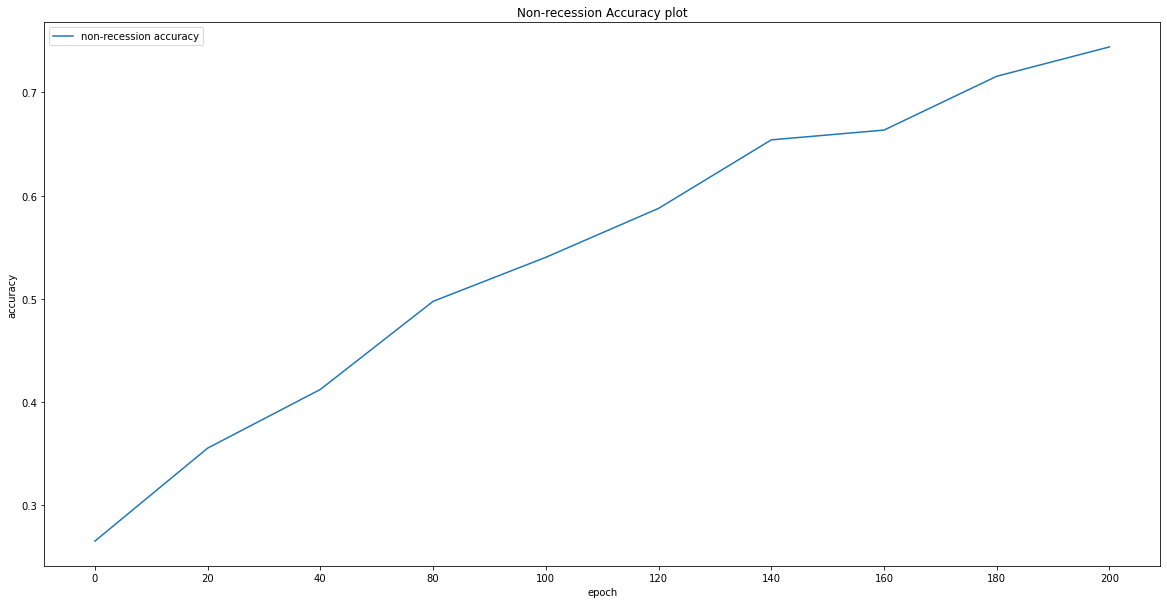

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

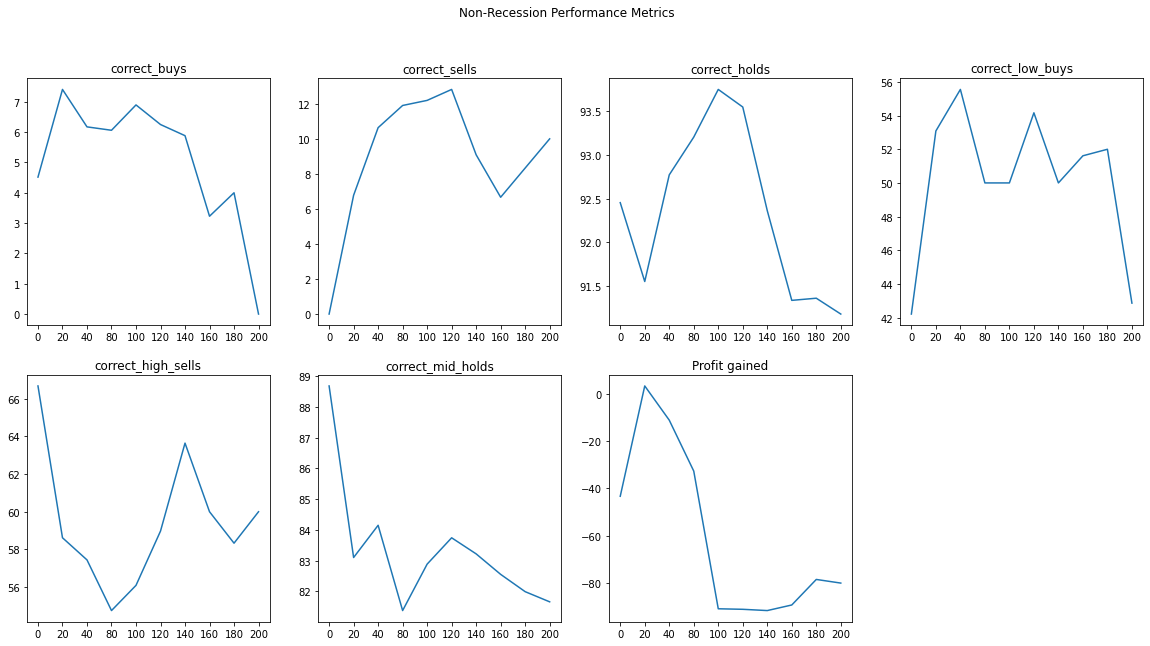

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

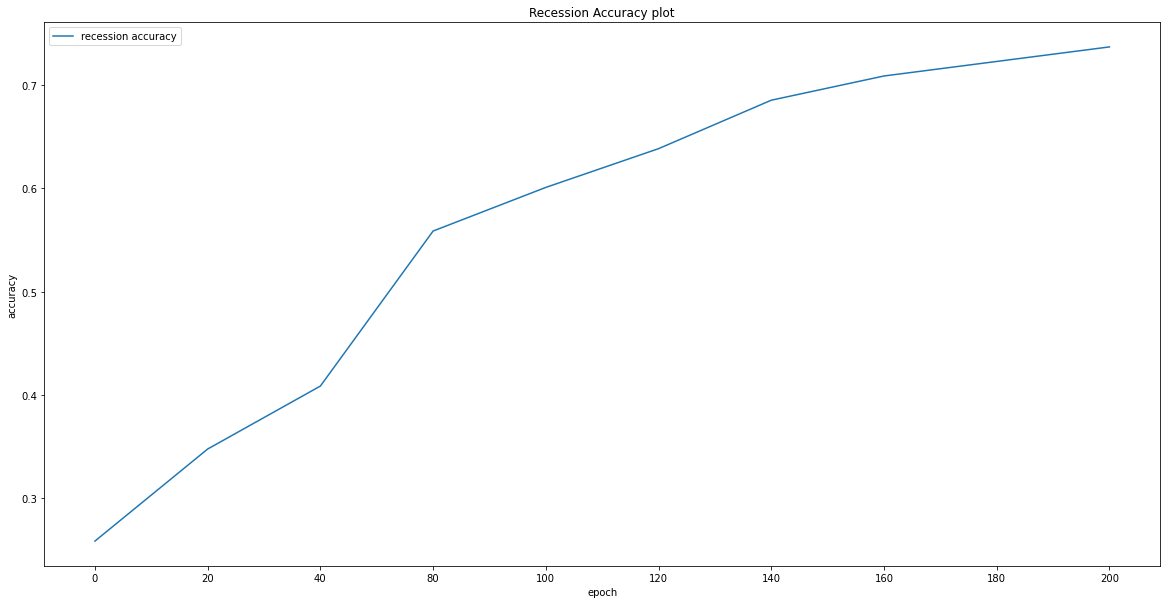

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

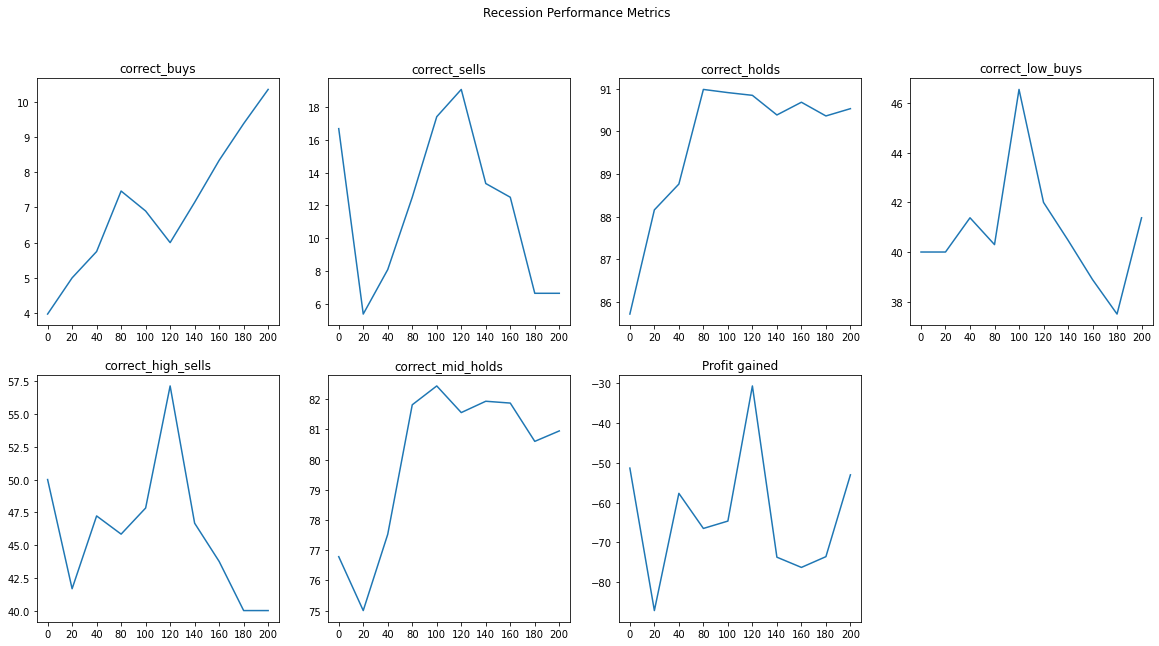

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### JP Morgan

In [47]:
nr_test_sets = ['JPM']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14         OBV_7  labels
Date                                                                
2018-12-06   107.230003  109.628444 -81.910265 -1.924741e+09     2.0
2018-12-07   105.190002  108.945607 -76.923030 -1.951955e+09     2.0
2018-12-10   103.290001  108.075514 -95.904060 -1.971203e+09     2.0
2018-12-11   101.360001  107.042358 -84.717107 -1.994840e+09     2.0
2018-12-12   100.370003  106.015842 -91.991154 -2.011700e+09     2.0


In [48]:
r_test_sets = ['JPM']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1
        
    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14        OBV_7  labels
Date                                                               
2019-12-06   133.059998  131.187618  -5.091646  270369900.0     2.0
2019-12-09   135.039993  131.780291 -10.292145  280540500.0     2.0
2019-12-10   134.410004  132.184862 -19.054168  272042300.0     2.0
2019-12-11   134.500000  132.541037 -17.802480  279575200.0     2.0
2019-12-12   134.179993  132.793184 -22.253207  270563300.0     2.0


### Training Data

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


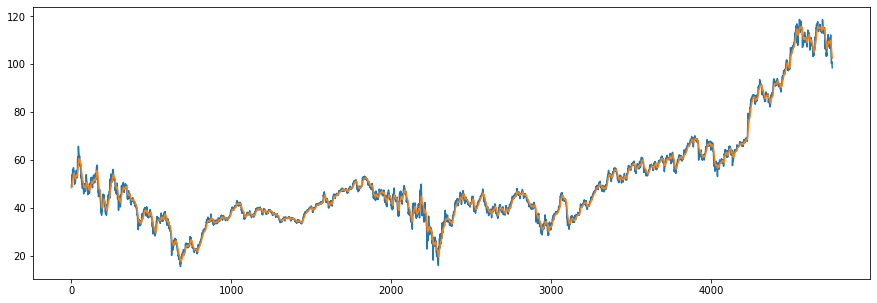

In [49]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/JPM_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1
    
X  = np.array(sequential).reshape(-1, 25, 4)
y = labels
y = np.array(y)

In [50]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [51]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [52]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [53]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [54]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('JPM')]
    y = nr_test_data['{}_y'.format('JPM')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('JPM'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('JPM'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'JPM')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'JPM'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'JPM'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('JPM')]
    y = r_test_data['{}_y'.format('JPM')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('JPM'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('JPM'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'JPM')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'JPM'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'JPM'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.699186991869919, 1: 7.427450980392157, 2: 0.36556649295502797}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 1s 43ms/step - loss: 0.2899 - accuracy: 0.5649 - mse: 0.4407 - weighted_accuracy: 0.3277 - weighted_mse: 0.5298 - val_loss: 0.2990 - val_accuracy: 0.0454 - val_mse: 0.3548 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3548
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2122 - accuracy: 0.3986 - mse: 0.7584 - weighted_accuracy: 0.4279 - weighted_mse: 0.7544 - val_loss: 0.2897 - val_accuracy: 0.0454 - val_mse: 0.3865 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3865
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1904 - accuracy: 0.3242 - mse: 0.9975 - weighted_accuracy: 0.4844 - weighted_mse: 0.9639 - val_loss: 0.2810 - val_accuracy: 0.0454 - val_mse: 0.4292 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.4292
Epoch 4/20
30/30 [==============================] - 0s

7/7 [==============================] - 0s 4ms/step - loss: 0.1764 - accuracy: 0.4292 - mse: 1.3316 - weighted_accuracy: 0.4292 - weighted_mse: 1.3316


<ipython-input-54-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.17640867829322815
Test accuracy: 0.4292237460613251


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 4
actual holds but predicted buy: 66
actual holds but predicted sell: 53
actual predicted holds: 78
Percentage buys correct: 10.81081081081081%
Percentage sells correct: 12.903225806451612%
Percentage holds correct: 93.97590361445783%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 52.054794520547944%
Percentage high sells correct: 51.61290322580645%
Percentage mid holds correct: 84.33734939759036%


Capital: 100
Share price: $0.8109157602043964
Shares owned at the moment: 122
Cash capital at the moment: $0.7962150175150668


Price increase from previously bought: -58.95889804740813%
Share price: $0.33372398799583336
Shares owned at the moment: 0
Cash capital at the moment: $41

Epoch 17/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1325 - accuracy: 0.4039 - mse: 1.8925 - weighted_accuracy: 0.7265 - weighted_mse: 1.7893 - val_loss: 0.1984 - val_accuracy: 0.3252 - val_mse: 1.9494 - val_weighted_accuracy: 0.3252 - val_weighted_mse: 1.9494
Epoch 18/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1314 - accuracy: 0.4256 - mse: 1.8877 - weighted_accuracy: 0.7402 - weighted_mse: 1.7882 - val_loss: 0.1957 - val_accuracy: 0.3411 - val_mse: 1.9655 - val_weighted_accuracy: 0.3411 - val_weighted_mse: 1.9655
Epoch 19/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1313 - accuracy: 0.4414 - mse: 1.8958 - weighted_accuracy: 0.7270 - weighted_mse: 1.8081 - val_loss: 0.1927 - val_accuracy: 0.3664 - val_mse: 1.9522 - val_weighted_accuracy: 0.3664 - val_weighted_mse: 1.9522
Epoch 20/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1307 - accuracy: 0.4232 - mse: 1.9454 - weighted_accuracy: 0.7371 - weig

<ipython-input-54-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.19231359660625458
Test accuracy: 0.4155251085758209


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 62
actual holds but predicted sell: 60
actual predicted holds: 75
Percentage buys correct: 11.267605633802816%
Percentage sells correct: 11.594202898550725%
Percentage holds correct: 94.9367088607595%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 52.857142857142854%
Percentage high sells correct: 52.17391304347826%
Percentage mid holds correct: 82.27848101265823%


Capital: 100
Share price: $0.8173596680482467
Shares owned at the moment: 122
Cash capital at the moment: $0.007896329483727982


Price increase from previously bought: -59.28245827325591%
Share price: $0.33372398799583336
Shares owned at the moment: 0
Cash capital at the moment: $

Epoch 14/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1191 - accuracy: 0.5240 - mse: 2.2296 - weighted_accuracy: 0.7782 - weighted_mse: 2.1766 - val_loss: 0.1978 - val_accuracy: 0.4002 - val_mse: 2.2277 - val_weighted_accuracy: 0.4002 - val_weighted_mse: 2.2277
Epoch 15/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1179 - accuracy: 0.5111 - mse: 2.2648 - weighted_accuracy: 0.7886 - weighted_mse: 2.1896 - val_loss: 0.1864 - val_accuracy: 0.4319 - val_mse: 2.2821 - val_weighted_accuracy: 0.4319 - val_weighted_mse: 2.2821
Epoch 16/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1175 - accuracy: 0.5301 - mse: 2.2538 - weighted_accuracy: 0.7939 - weighted_mse: 2.1840 - val_loss: 0.1937 - val_accuracy: 0.4044 - val_mse: 2.4203 - val_weighted_accuracy: 0.4044 - val_weighted_mse: 2.4203
Epoch 17/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1165 - accuracy: 0.5166 - mse: 2.2997 - weighted_accuracy: 0.7925 - weig

<ipython-input-54-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 56
actual holds but predicted sell: 54
actual predicted holds: 87
Percentage buys correct: 10.9375%
Percentage sells correct: 12.698412698412698%
Percentage holds correct: 94.56521739130434%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 53.96825396825397%
Percentage mid holds correct: 83.69565217391305%


Capital: 100
Share price: $0.8173596680482467
Shares owned at the moment: 122
Cash capital at the moment: $0.007896329483727982


Price increase from previously bought: -73.74486282134623%
Share price: $0.21518904906980119
Shares owned at the moment: 0
Cash capital at the moment: $26.188764390036553


Share price: $0.10038497067528372
Shares owned at the mom

<ipython-input-54-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.18275627493858337
Test accuracy: 0.5114155411720276


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 52
actual holds but predicted sell: 47
actual predicted holds: 98
Percentage buys correct: 11.666666666666666%
Percentage sells correct: 12.962962962962964%
Percentage holds correct: 93.33333333333333%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 57.6271186440678%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 83.80952380952381%


Capital: 100
Share price: $0.8173596680482467
Shares owned at the moment: 122
Cash capital at the moment: $0.007896329483727982


Price increase from previously bought: -73.74486282134623%
Share price: $0.21518904906980119
Shares owned at the moment: 0
Cash capital at the moment: $2

<ipython-input-54-f8274daa7903>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 0s 16ms/step - loss: 0.0972 - accuracy: 0.6734 - mse: 2.9253 - weighted_accuracy: 0.8577 - weighted_mse: 2.9253 - val_loss: 0.1858 - val_accuracy: 0.5100 - val_mse: 3.0268 - val_weighted_accuracy: 0.5100 - val_weighted_mse: 3.0268
Epoch 2/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0969 - accuracy: 0.6204 - mse: 2.9794 - weighted_accuracy: 0.8458 - weighted_mse: 2.9593 - val_loss: 0.2016 - val_accuracy: 0.4572 - val_mse: 2.9443 - val_weighted_accuracy: 0.4572 - val_weighted_mse: 2.9443
Epoch 3/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0952 - accuracy: 0.6563 - mse: 2.9884 - weighted_accuracy: 0.8551 - weighted_mse: 2.9722 - val_loss: 0.1964 - val_accuracy: 0.4815 - val_mse: 3.1998 - val_weighted_accuracy: 0.4815 - val_weighted_mse: 3.1998
Epoch 4/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0957 - accuracy: 0.6407 - mse: 3.0463 - weighted_accuracy: 0.8554 - weighted_mse: 3.039

7/7 [==============================] - 0s 6ms/step - loss: 0.1768 - accuracy: 0.5936 - mse: 3.8750 - weighted_accuracy: 0.5936 - weighted_mse: 3.8750


<ipython-input-54-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.17683380842208862
Test accuracy: 0.5936073064804077


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 4
actual holds but predicted buy: 41
actual holds but predicted sell: 39
actual predicted holds: 117
Percentage buys correct: 12.5%
Percentage sells correct: 15.217391304347826%
Percentage holds correct: 93.6%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 53.191489361702125%
Percentage high sells correct: 58.69565217391305%
Percentage mid holds correct: 85.6%


Capital: 100
Share price: $0.8173596680482467
Shares owned at the moment: 122
Cash capital at the moment: $0.007896329483727982


Price increase from previously bought: -73.74486282134623%
Share price: $0.21518904906980119
Shares owned at the moment: 0
Cash capital at the moment: $26.188764390036553


Share price: $0.1

<ipython-input-54-f8274daa7903>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 1s 22ms/step - loss: 0.0815 - accuracy: 0.7439 - mse: 3.6599 - weighted_accuracy: 0.8893 - weighted_mse: 3.6338 - val_loss: 0.1936 - val_accuracy: 0.5713 - val_mse: 3.8131 - val_weighted_accuracy: 0.5713 - val_weighted_mse: 3.8131
Epoch 2/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0820 - accuracy: 0.7080 - mse: 3.7293 - weighted_accuracy: 0.8855 - weighted_mse: 3.6973 - val_loss: 0.2041 - val_accuracy: 0.5248 - val_mse: 3.5978 - val_weighted_accuracy: 0.5248 - val_weighted_mse: 3.5978
Epoch 3/20
30/30 [==============================] - 1s 26ms/step - loss: 0.0797 - accuracy: 0.7402 - mse: 3.7529 - weighted_accuracy: 0.8917 - weighted_mse: 3.7078 - val_loss: 0.2001 - val_accuracy: 0.5290 - val_mse: 3.9770 - val_weighted_accuracy: 0.5290 - val_weighted_mse: 3.9770
Epoch 4/20
30/30 [==============================] - 1s 23ms/step - loss: 0.0808 - accuracy: 0.7165 - mse: 3.8214 - weighted_accuracy: 0.8907 - weighted_mse: 3.772

7/7 [==============================] - 0s 6ms/step - loss: 0.1723 - accuracy: 0.6164 - mse: 4.7441 - weighted_accuracy: 0.6164 - weighted_mse: 4.7441
Test loss: 0.17227286100387573
Test accuracy: 0.6164383292198181




<ipython-input-54-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 5
actual holds but predicted buy: 42
actual holds but predicted sell: 31
actual predicted holds: 124
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 18.42105263157895%
Percentage holds correct: 91.85185185185185%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 60.526315789473685%
Percentage mid holds correct: 83.70370370370371%


Capital: 100
Share price: $0.8173596680482467
Shares owned at the moment: 122
Cash capital at the moment: $0.007896329483727982


Price increase from previously bought: -73.74486282134623%
Share price: $0.21518904906980119
Shares owned at the moment: 0
Cash capital at the moment: $26.188764390036553


Share price: $0.10038497067528372
Shares owned

<ipython-input-54-f8274daa7903>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['previous_1d'] = df['previous_1d'].shift(-1)
<ipython-input-54-f8274daa7903>:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna

30/30 [==============================] - 1s 24ms/step - loss: 0.0671 - accuracy: 0.8023 - mse: 4.6332 - weighted_accuracy: 0.9145 - weighted_mse: 4.5037 - val_loss: 0.1985 - val_accuracy: 0.6262 - val_mse: 5.0407 - val_weighted_accuracy: 0.6262 - val_weighted_mse: 5.0407
Epoch 2/20
30/30 [==============================] - 1s 25ms/step - loss: 0.0677 - accuracy: 0.7703 - mse: 4.6630 - weighted_accuracy: 0.9084 - weighted_mse: 4.5601 - val_loss: 0.2008 - val_accuracy: 0.5966 - val_mse: 4.4564 - val_weighted_accuracy: 0.5966 - val_weighted_mse: 4.4564
Epoch 3/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0659 - accuracy: 0.7944 - mse: 4.7286 - weighted_accuracy: 0.9152 - weighted_mse: 4.5957 - val_loss: 0.1983 - val_accuracy: 0.6272 - val_mse: 4.9607 - val_weighted_accuracy: 0.6272 - val_weighted_mse: 4.9607
Epoch 4/20
30/30 [==============================] - 1s 26ms/step - loss: 0.0676 - accuracy: 0.7793 - mse: 4.8305 - weighted_accuracy: 0.9137 - weighted_mse: 4.684

7/7 [==============================] - 0s 6ms/step - loss: 0.1729 - accuracy: 0.6621 - mse: 6.0590 - weighted_accuracy: 0.6621 - weighted_mse: 6.0590


<ipython-input-54-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.1729423850774765
Test accuracy: 0.6621004343032837


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 6
actual sells but predicted hold: 6
actual holds but predicted buy: 30
actual holds but predicted sell: 32
actual predicted holds: 135
Percentage buys correct: 11.764705882352942%
Percentage sells correct: 15.789473684210526%
Percentage holds correct: 91.83673469387755%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 57.57575757575758%
Percentage high sells correct: 63.1578947368421%
Percentage mid holds correct: 83.6734693877551%


Capital: 100
Share price: $0.7279922518370321
Shares owned at the moment: 136
Cash capital at the moment: $0.7207846479765863


Price increase from previously bought: -54.88800917151%
Share price: $0.329314930325012
Shares owned at the moment: 0
Cash capital at the moment: $45.384451

<ipython-input-54-f8274daa7903>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['previous_1d'] = df['previous_1d'].shift(-1)
<ipython-input-54-f8274daa7903>:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna

30/30 [==============================] - 1s 19ms/step - loss: 0.0572 - accuracy: 0.8390 - mse: 5.8315 - weighted_accuracy: 0.9317 - weighted_mse: 5.5522 - val_loss: 0.2217 - val_accuracy: 0.6367 - val_mse: 6.1521 - val_weighted_accuracy: 0.6367 - val_weighted_mse: 6.1521
Epoch 2/20
30/30 [==============================] - 0s 16ms/step - loss: 0.0579 - accuracy: 0.8131 - mse: 5.8081 - weighted_accuracy: 0.9203 - weighted_mse: 5.5816 - val_loss: 0.2192 - val_accuracy: 0.6283 - val_mse: 5.4599 - val_weighted_accuracy: 0.6283 - val_weighted_mse: 5.4599
Epoch 3/20
30/30 [==============================] - 1s 22ms/step - loss: 0.0546 - accuracy: 0.8350 - mse: 5.8804 - weighted_accuracy: 0.9359 - weighted_mse: 5.6020 - val_loss: 0.2089 - val_accuracy: 0.6779 - val_mse: 6.1302 - val_weighted_accuracy: 0.6779 - val_weighted_mse: 6.1302
Epoch 4/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0570 - accuracy: 0.8123 - mse: 5.9574 - weighted_accuracy: 0.9257 - weighted_mse: 5.664

7/7 [==============================] - 0s 8ms/step - loss: 0.1644 - accuracy: 0.7215 - mse: 7.3971 - weighted_accuracy: 0.7215 - weighted_mse: 7.3971
Test loss: 0.16443221271038055
Test accuracy: 0.7214611768722534




<ipython-input-54-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 23
actual holds but predicted sell: 21
actual predicted holds: 153
Percentage buys correct: 11.538461538461538%
Percentage sells correct: 8.695652173913043%
Percentage holds correct: 90.0%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 64.0%
Percentage high sells correct: 56.52173913043478%
Percentage mid holds correct: 82.94117647058823%


Capital: 100
Share price: $0.7279922518370321
Shares owned at the moment: 136
Cash capital at the moment: $0.7207846479765863


Price increase from previously bought: -72.75189412750669%
Share price: $0.19890960079779396
Shares owned at the moment: 0
Cash capital at the moment: $27.69809816577819


Share price: $0.34101583633014876
Shares owned at the moment: 80
Cash capi

<ipython-input-54-f8274daa7903>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 1s 21ms/step - loss: 0.0473 - accuracy: 0.8691 - mse: 7.2230 - weighted_accuracy: 0.9464 - weighted_mse: 6.6979 - val_loss: 0.2329 - val_accuracy: 0.6790 - val_mse: 7.5485 - val_weighted_accuracy: 0.6790 - val_weighted_mse: 7.5485
Epoch 2/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0483 - accuracy: 0.8485 - mse: 7.1139 - weighted_accuracy: 0.9408 - weighted_mse: 6.6905 - val_loss: 0.2316 - val_accuracy: 0.6727 - val_mse: 6.8100 - val_weighted_accuracy: 0.6727 - val_weighted_mse: 6.8100
Epoch 3/20
30/30 [==============================] - 1s 31ms/step - loss: 0.0454 - accuracy: 0.8651 - mse: 7.2194 - weighted_accuracy: 0.9487 - weighted_mse: 6.7151 - val_loss: 0.2238 - val_accuracy: 0.7064 - val_mse: 7.4501 - val_weighted_accuracy: 0.7064 - val_weighted_mse: 7.4501
Epoch 4/20
30/30 [==============================] - 1s 30ms/step - loss: 0.0476 - accuracy: 0.8524 - mse: 7.3001 - weighted_accuracy: 0.9441 - weighted_mse: 6.786

7/7 [==============================] - 0s 9ms/step - loss: 0.1524 - accuracy: 0.7808 - mse: 9.1751 - weighted_accuracy: 0.7808 - weighted_mse: 9.1751


<ipython-input-54-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.15244033932685852
Test accuracy: 0.7808219194412231


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 16
actual holds but predicted sell: 15
actual predicted holds: 166
Percentage buys correct: 15.789473684210526%
Percentage sells correct: 11.764705882352942%
Percentage holds correct: 90.7103825136612%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 57.89473684210526%
Percentage high sells correct: 58.8235294117647%
Percentage mid holds correct: 83.51648351648352%


Capital: 100
Share price: $0.7279922518370321
Shares owned at the moment: 136
Cash capital at the moment: $0.7207846479765863


Price increase from previously bought: -72.75189412750669%
Share price: $0.19890960079779396
Shares owned at the moment: 0
Cash capital at the moment: $27

<ipython-input-54-f8274daa7903>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

30/30 [==============================] - 1s 27ms/step - loss: 0.0394 - accuracy: 0.8936 - mse: 8.7683 - weighted_accuracy: 0.9611 - weighted_mse: 7.9236 - val_loss: 0.2485 - val_accuracy: 0.7096 - val_mse: 9.4298 - val_weighted_accuracy: 0.7096 - val_weighted_mse: 9.4298
Epoch 2/20
30/30 [==============================] - 1s 26ms/step - loss: 0.0412 - accuracy: 0.8812 - mse: 8.6076 - weighted_accuracy: 0.9527 - weighted_mse: 7.8611 - val_loss: 0.2497 - val_accuracy: 0.6895 - val_mse: 8.2856 - val_weighted_accuracy: 0.6895 - val_weighted_mse: 8.2856
Epoch 3/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0388 - accuracy: 0.8865 - mse: 8.7168 - weighted_accuracy: 0.9566 - weighted_mse: 7.8985 - val_loss: 0.2453 - val_accuracy: 0.7360 - val_mse: 9.2667 - val_weighted_accuracy: 0.7360 - val_weighted_mse: 9.2667
Epoch 4/20
30/30 [==============================] - 1s 24ms/step - loss: 0.0409 - accuracy: 0.8794 - mse: 8.7996 - weighted_accuracy: 0.9540 - weighted_mse: 7.966

7/7 [==============================] - 0s 7ms/step - loss: 0.1694 - accuracy: 0.8037 - mse: 10.7797 - weighted_accuracy: 0.8037 - weighted_mse: 10.7797
Test loss: 0.16938604414463043
Test accuracy: 0.8036529421806335




<ipython-input-54-f8274daa7903>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 14
actual holds but predicted sell: 12
actual predicted holds: 171
Percentage buys correct: 17.647058823529413%
Percentage sells correct: 14.285714285714286%
Percentage holds correct: 90.95744680851064%
actual buys: 10
actual sells: 12
actual holds: 197


Percentage low buys correct: 64.70588235294117%
Percentage high sells correct: 57.142857142857146%
Percentage mid holds correct: 83.42245989304813%


Capital: 100
Share price: $0.7279922518370321
Shares owned at the moment: 136
Cash capital at the moment: $0.7207846479765863


Price increase from previously bought: -72.75189412750669%
Share price: $0.19890960079779396
Shares owned at the moment: 0
Cash capital at the moment: $27.69809816577819


Share price: $0.34101583633014876
Shares owned

<ipython-input-54-f8274daa7903>:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-54-f8274daa7903>:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-54-f8274daa7903>:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

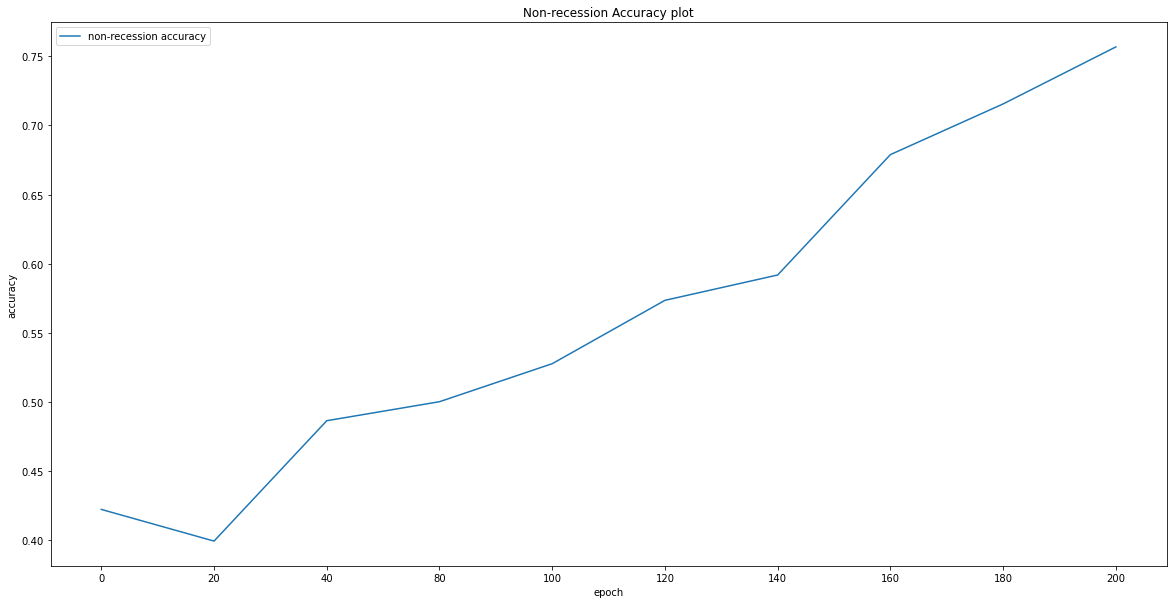

In [55]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

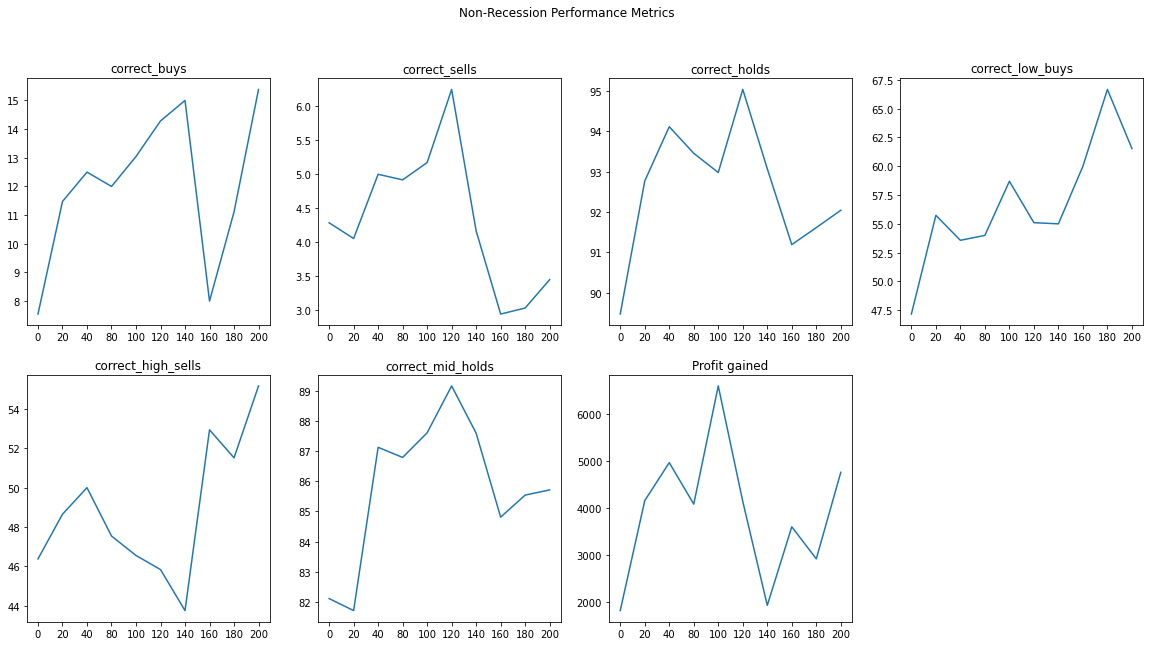

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

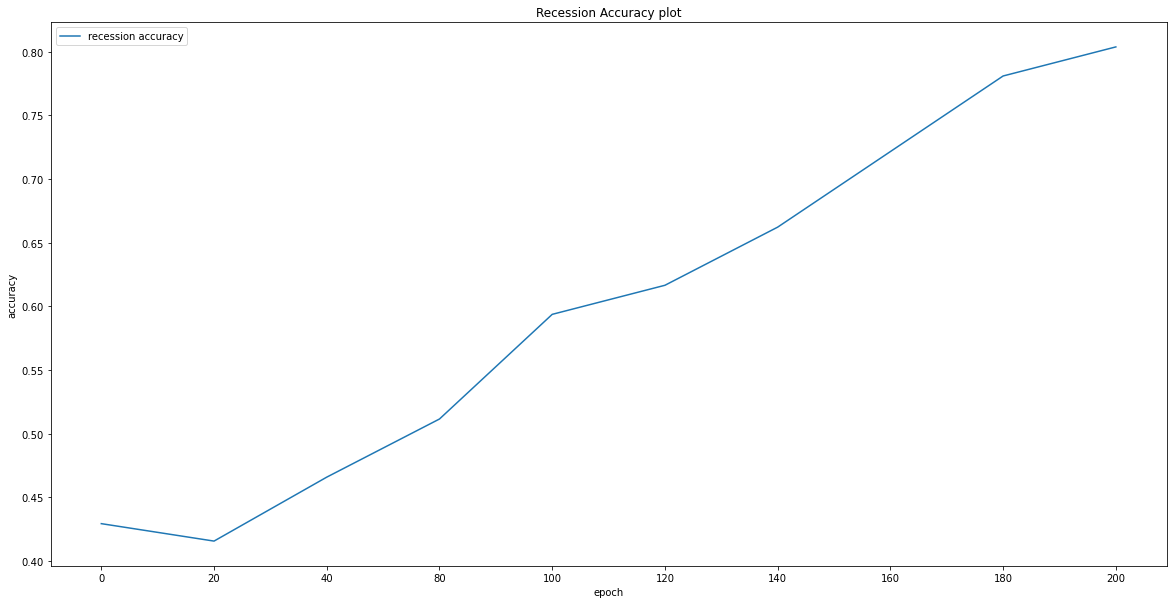

In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(r_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

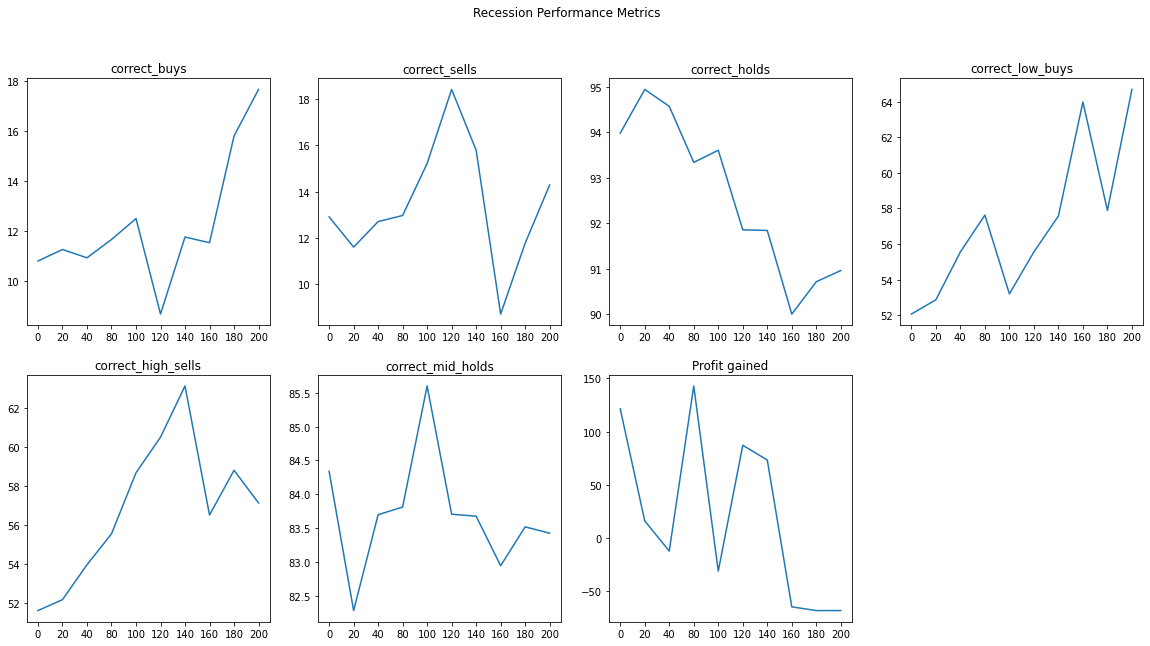

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

### American Axle

In [59]:
nr_test_sets = ['AXL']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1

    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2018-12-06        12.27  12.266266 -43.949026  234486200.0     2.0
2018-12-07        11.98  12.222225 -62.420426  231459100.0     2.0
2018-12-10        11.33  12.084959 -93.678180  229051600.0     2.0
2018-12-11        11.38  11.976504 -73.831760  231349000.0     2.0
2018-12-12        11.32  11.875503 -76.635518  229316700.0     2.0


In [60]:
r_test_sets = ['AXL']
r_test_data = {}

for name in r_test_sets:

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2
    print(df.head())
    
    labels = []
    data_25 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 24:
            data_25.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_25_arr = min_max_scaler.fit_transform(data_25)
            sequential.append(data_25_arr)
            data_25 = data_25[1:25]
        else:
            data_25.append(np.array(i[0:-1]))
            count+= 1     
        
    X  = np.array(sequential).reshape(-1, 25, 4)
    y = labels
    y = np.array(y)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d    EMA_12   willr_14       OBV_7  labels
Date                                                            
2019-12-06         9.49  9.751830 -78.151251 -15220600.0     2.0
2019-12-09        10.09  9.803856 -27.731074 -13947000.0     2.0
2019-12-10        10.02  9.837109 -33.613398 -14784200.0     2.0
2019-12-11        10.06  9.871400 -30.252058 -12899200.0     2.0
2019-12-12        10.53  9.972723  -7.801457 -10425400.0     0.0


### Training Data

            previous_1d     EMA_12   willr_14     OBV_7  labels
Date                                                           
2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


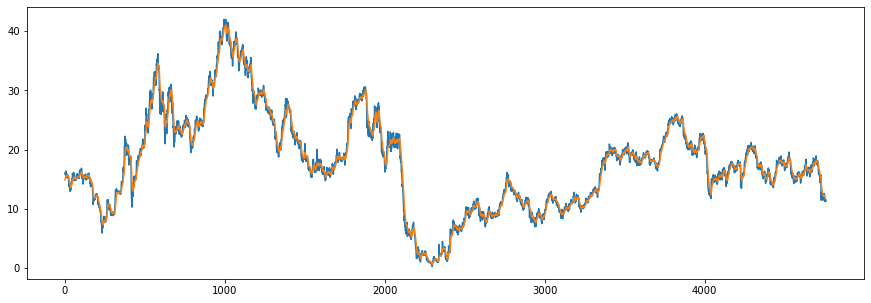

In [61]:
seed = 10
df = pd.read_csv('data/cyclic_tickers/initial_indicators/AXL_data.csv')
df.set_index('Date', inplace=True)
print(df.head())

plt.figure(figsize=(15,5))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
plt.show()

labels = []
data_25 = []
sequential = []
count = 0

for i in df.values:
    if count == 24:
        data_25.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_25_arr = min_max_scaler.fit_transform(data_25)
        sequential.append(data_25_arr)
        data_25 = data_25[1:25]
    else:
        data_25.append(np.array(i[0:-1]))
        count+= 1

X  = np.array(sequential).reshape(-1, 25, 4)
y = labels
y = np.array(y)

In [62]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [63]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [64]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [66]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "DBS_CNN_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
nr_log  = pd.DataFrame(columns = column_names)
r_log  = pd.DataFrame(columns = column_names)

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    print('\n')
    print('Non-Recession Test')
    print('\n')
        
    X = nr_test_data['{}_X'.format('AXL')]
    y = nr_test_data['{}_y'.format('AXL')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('AXL'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data.csv".format('AXL'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    nr_length = len(nr_log)
    log.loc[df_length] = logger
    nr_log.loc[nr_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_non_recession.csv'.format(experiment,'AXL')):
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'AXL'))
    else:
        log.to_csv('{}_{}_non_recession.csv'.format(experiment,'AXL'), mode='a', header=False)
    
    
    print('\n')
    print('Recession Test')
    print('\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    log  = pd.DataFrame(columns = column_names)
    logger = []
        
    X = r_test_data['{}_X'.format('AXL')]
    y = r_test_data['{}_y'.format('AXL')]

    score = model.evaluate(X, y)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('\n')
    logger.append(score[1]) 

    predictions = model.predict(X)
    predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
    actual = [np.argmax(i, axis=None, out=None) for i in y]

    df = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test2.csv".format('AXL'))
    df.set_index('Date', inplace=True)
    df2 = pd.read_csv("data/cyclic_tickers/initial_indicators/{}_data_test.csv".format('AXL'))
    df2.set_index('Date', inplace=True)
    df2 = df2.iloc[-10:]
    df2 = pd.concat([df2,df])
    df = df2.iloc[24:]
    df['predictions'] = predictions
    df['actual'] = actual
    df['previous_1d'] = df['previous_1d'].shift(-1)
    df.dropna(inplace=True)

    prediction = df['predictions'].values.tolist()
    price = df['previous_1d'].values.tolist()

    logger = pred_acc(actual, predictions, logger)
    print('\n')
    logger = correct_maxima_minima(prediction, price, logger)
    print('\n')
    logger = profit(prediction, price, logger)

    log  = pd.DataFrame(columns = column_names)
    df_length = len(log)
    r_length = len(r_log)
    log.loc[df_length] = logger
    r_log.loc[r_length] = logger
    print(log.head())
    logger = []
    
    if not os.path.exists('{}_{}_recession.csv'.format(experiment,'AXL')):
        log.to_csv('{}_{}_recession.csv'.format(experiment,'AXL'))
    else:
        log.to_csv('{}_{}_recession.csv'.format(experiment,'AXL'), mode='a', header=False)
    
    epochs = epochs + 20
    
nr_log_hist['epochs_logs'] = nr_log
r_log_hist['epochs_logs'] = r_log

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


{0: 7.256704980842912, 1: 7.298651252408478, 2: 0.36694759275404437}



RUNNING EPOCHS 0 - 20



Epoch 1/20
30/30 [==============================] - 2s 52ms/step - loss: 0.2872 - accuracy: 0.5686 - mse: 0.4423 - weighted_accuracy: 0.3292 - weighted_mse: 0.5263 - val_loss: 0.2987 - val_accuracy: 0.0422 - val_mse: 0.3551 - val_weighted_accuracy: 0.0422 - val_weighted_mse: 0.3551
Epoch 2/20
30/30 [==============================] - 0s 10ms/step - loss: 0.2125 - accuracy: 0.4047 - mse: 0.7650 - weighted_accuracy: 0.4113 - weighted_mse: 0.7703 - val_loss: 0.2888 - val_accuracy: 0.0465 - val_mse: 0.3857 - val_weighted_accuracy: 0.0465 - val_weighted_mse: 0.3857
Epoch 3/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1940 - accuracy: 0.3205 - mse: 1.0114 - weighted_accuracy: 0.4751 - weighted_mse: 0.9872 - val_loss: 0.2781 - val_accuracy: 0.0465 - val_mse: 0.4238 - val_weighted_accuracy: 0.0465 - val_weighted_mse: 0.4238
Epoch 4/20
30/30 [==============================] - 0s

7/7 [==============================] - 0s 6ms/step - loss: 0.1922 - accuracy: 0.2831 - mse: 1.2675 - weighted_accuracy: 0.2831 - weighted_mse: 1.2675


<ipython-input-66-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.19218195974826813
Test accuracy: 0.2831050157546997


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 77
actual holds but predicted sell: 71
actual predicted holds: 49
Percentage buys correct: 10.227272727272727%
Percentage sells correct: 5.333333333333333%
Percentage holds correct: 87.5%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 49.42528735632184%
Percentage high sells correct: 52.0%
Percentage mid holds correct: 82.14285714285714%


Capital: 100
Share price: $0.6915789433232307
Shares owned at the moment: 144
Cash capital at the moment: $0.13876689989878344


Price increase from previously bought: -77.68693378584712%
Share price: $0.1547368268326052
Shares owned at the moment: 0
Cash capital at the moment: $22.35959418036822


Share pri

Epoch 13/20
30/30 [==============================] - 0s 9ms/step - loss: 0.1421 - accuracy: 0.4050 - mse: 1.5559 - weighted_accuracy: 0.6905 - weighted_mse: 1.4669 - val_loss: 0.1935 - val_accuracy: 0.3939 - val_mse: 1.5823 - val_weighted_accuracy: 0.3939 - val_weighted_mse: 1.5823
Epoch 14/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1411 - accuracy: 0.4118 - mse: 1.5709 - weighted_accuracy: 0.7021 - weighted_mse: 1.4773 - val_loss: 0.1910 - val_accuracy: 0.3833 - val_mse: 1.6497 - val_weighted_accuracy: 0.3833 - val_weighted_mse: 1.6497
Epoch 15/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1399 - accuracy: 0.3733 - mse: 1.5908 - weighted_accuracy: 0.6989 - weighted_mse: 1.4855 - val_loss: 0.1780 - val_accuracy: 0.4509 - val_mse: 1.5693 - val_weighted_accuracy: 0.4509 - val_weighted_mse: 1.5693
Epoch 16/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1386 - accuracy: 0.4221 - mse: 1.5964 - weighted_accuracy: 0.7132 - weigh

<ipython-input-66-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.18246789276599884
Test accuracy: 0.388127863407135


number of predictions: 219
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 3
actual predicted sells: 5
actual sells but predicted hold: 3
actual holds but predicted buy: 58
actual holds but predicted sell: 67
actual predicted holds: 72
Percentage buys correct: 11.594202898550725%
Percentage sells correct: 6.944444444444445%
Percentage holds correct: 92.3076923076923%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 54.411764705882355%
Percentage high sells correct: 58.333333333333336%
Percentage mid holds correct: 85.8974358974359%


Capital: 100
Share price: $0.7323683459689425
Shares owned at the moment: 136
Cash capital at the moment: $0.1239991868314263


Price increase from previously bought: -78.92966450609059%
Share price: $0.1547368268326052
Shares owned at the moment: 0
Cash capital at the moment: $21.11

Epoch 10/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1266 - accuracy: 0.4728 - mse: 1.8019 - weighted_accuracy: 0.7574 - weighted_mse: 1.7030 - val_loss: 0.1964 - val_accuracy: 0.3960 - val_mse: 1.8463 - val_weighted_accuracy: 0.3960 - val_weighted_mse: 1.8463
Epoch 11/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1251 - accuracy: 0.4971 - mse: 1.8269 - weighted_accuracy: 0.7589 - weighted_mse: 1.7377 - val_loss: 0.2208 - val_accuracy: 0.3495 - val_mse: 1.9154 - val_weighted_accuracy: 0.3495 - val_weighted_mse: 1.9154
Epoch 12/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1246 - accuracy: 0.4900 - mse: 1.8341 - weighted_accuracy: 0.7673 - weighted_mse: 1.7372 - val_loss: 0.1827 - val_accuracy: 0.4593 - val_mse: 1.8409 - val_weighted_accuracy: 0.4593 - val_weighted_mse: 1.8409
Epoch 13/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1242 - accuracy: 0.5079 - mse: 1.8419 - weighted_accuracy: 0.7684 - weig

<ipython-input-66-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu





RUNNING EPOCHS 60 - 80



Epoch 1/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1176 - accuracy: 0.5454 - mse: 1.9709 - weighted_accuracy: 0.8004 - weighted_mse: 1.8703 - val_loss: 0.1740 - val_accuracy: 0.5259 - val_mse: 2.0831 - val_weighted_accuracy: 0.5259 - val_weighted_mse: 2.0831
Epoch 2/20
30/30 [==============================] - 0s 16ms/step - loss: 0.1154 - accuracy: 0.5549 - mse: 1.9939 - weighted_accuracy: 0.7984 - weighted_mse: 1.9082 - val_loss: 0.2012 - val_accuracy: 0.4424 - val_mse: 2.1414 - val_weighted_accuracy: 0.4424 - val_weighted_mse: 2.1414
Epoch 3/20
30/30 [==============================] - 0s 10ms/step - loss: 0.1144 - accuracy: 0.5385 - mse: 2.0377 - weighted_accuracy: 0.8033 - weighted_mse: 1.9398 - val_loss: 0.1823 - val_accuracy: 0.5090 - val_mse: 2.1312 - val_weighted_accuracy: 0.5090 - val_weighted_mse: 2.1312
Epoch 4/20
30/30 [==============================] - 0s 12ms/step - loss: 0.1151 - accuracy: 0.5438 - mse: 2.0344 - weight



Recession Test


7/7 [==============================] - 0s 5ms/step - loss: 0.1743 - accuracy: 0.5160 - mse: 2.3861 - weighted_accuracy: 0.5160 - weighted_mse: 2.3861


<ipython-input-66-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Test loss: 0.17428672313690186
Test accuracy: 0.5159817337989807


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 4
actual holds but predicted buy: 41
actual holds but predicted sell: 53
actual predicted holds: 103
Percentage buys correct: 8.695652173913043%
Percentage sells correct: 10.0%
Percentage holds correct: 91.15044247787611%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 55.55555555555556%
Percentage high sells correct: 56.666666666666664%
Percentage mid holds correct: 86.72566371681415%


Capital: 100
Share price: $0.48894737320923726
Shares owned at the moment: 203
Cash capital at the moment: $0.4707283674307803


Price increase from previously bought: -68.43986162886782%
Share price: $0.1547368268326052
Shares owned at the moment: 0
Cash capital at the moment: $31.795922380870

Epoch 14/20
30/30 [==============================] - 0s 15ms/step - loss: 0.0899 - accuracy: 0.6787 - mse: 2.8182 - weighted_accuracy: 0.8639 - weighted_mse: 2.7194 - val_loss: 0.1818 - val_accuracy: 0.5681 - val_mse: 2.9202 - val_weighted_accuracy: 0.5681 - val_weighted_mse: 2.9202
Epoch 15/20
30/30 [==============================] - 0s 11ms/step - loss: 0.0895 - accuracy: 0.6771 - mse: 2.8465 - weighted_accuracy: 0.8688 - weighted_mse: 2.7721 - val_loss: 0.1648 - val_accuracy: 0.6199 - val_mse: 3.1629 - val_weighted_accuracy: 0.6199 - val_weighted_mse: 3.1629
Epoch 16/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0894 - accuracy: 0.6935 - mse: 2.8770 - weighted_accuracy: 0.8802 - weighted_mse: 2.7779 - val_loss: 0.1593 - val_accuracy: 0.6463 - val_mse: 2.9005 - val_weighted_accuracy: 0.6463 - val_weighted_mse: 2.9005
Epoch 17/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0899 - accuracy: 0.6692 - mse: 2.8919 - weighted_accuracy: 0.8640 - weigh

<ipython-input-66-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

Epoch 1/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0860 - accuracy: 0.7088 - mse: 3.0230 - weighted_accuracy: 0.8749 - weighted_mse: 2.9074 - val_loss: 0.1597 - val_accuracy: 0.6547 - val_mse: 3.5397 - val_weighted_accuracy: 0.6547 - val_weighted_mse: 3.5397
Epoch 2/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0837 - accuracy: 0.7093 - mse: 3.0546 - weighted_accuracy: 0.8806 - weighted_mse: 2.9604 - val_loss: 0.1856 - val_accuracy: 0.5723 - val_mse: 3.2874 - val_weighted_accuracy: 0.5723 - val_weighted_mse: 3.2874
Epoch 3/20
30/30 [==============================] - 0s 9ms/step - loss: 0.0821 - accuracy: 0.7086 - mse: 3.1201 - weighted_accuracy: 0.8912 - weighted_mse: 3.0156 - val_loss: 0.1676 - val_accuracy: 0.6346 - val_mse: 3.2957 - val_weighted_accuracy: 0.6346 - val_weighted_mse: 3.2957
Epoch 4/20
30/30 [==============================] - 0s 10ms/step - loss: 0.0837 - accuracy: 0.7096 - mse: 3.1275 - weighted_accuracy: 0.8825 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.1598 - accuracy: 0.6530 - mse: 3.6513 - weighted_accuracy: 0.6530 - weighted_mse: 3.6513
Test loss: 0.15979540348052979
Test accuracy: 0.6529680490493774




<ipython-input-66-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 5
actual sells but predicted hold: 6
actual holds but predicted buy: 24
actual holds but predicted sell: 38
actual predicted holds: 135
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 11.363636363636363%
Percentage holds correct: 91.21621621621621%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 70.37037037037037%
Percentage high sells correct: 59.09090909090909%
Percentage mid holds correct: 86.39455782312925%


Capital: 100
Share price: $0.48894737320923726
Shares owned at the moment: 203
Cash capital at the moment: $0.4707283674307803


Price increase from previously bought: -68.9765982069972%
Share price: $0.15210525044443896
Shares owned at the moment: 0
Cash capital at the moment: $31.263181451591276


Share price: $0.6415789292063412
Shares owned at

<ipython-input-66-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 21
actual holds but predicted sell: 29
actual predicted holds: 147
Percentage buys correct: 12.5%
Percentage sells correct: 9.375%
Percentage holds correct: 90.1840490797546%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 70.83333333333333%
Percentage high sells correct: 53.125%
Percentage mid holds correct: 84.5679012345679%


Capital: 100
Share price: $0.48894737320923726
Shares owned at the moment: 203
Cash capital at the moment: $0.4707283674307803


Price increase from previously bought: -68.9765982069972%
Share price: $0.15210525044443896
Shares owned at the moment: 0
Cash capital at the moment: $31.263181451591276


Share price: $0.6415789292063412
Shares owned at the moment: 48
Cash capital at the mom

<ipython-input-66-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 16
actual holds but predicted sell: 30
actual predicted holds: 151
Percentage buys correct: 15.789473684210526%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 90.41916167664671%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 73.6842105263158%
Percentage high sells correct: 54.54545454545455%
Percentage mid holds correct: 85.5421686746988%


Capital: 100
Share price: $0.4613157897626264
Shares owned at the moment: 216
Cash capital at the moment: $0.08176783215368744


Price increase from previously bought: -67.11837931559054%
Share price: $0.15210525044443896
Shares owned at the moment: 0
Cash capital at the moment: $32.846151409388504


Share price: $0.6757894849942327
Shares owned at 

Epoch 19/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0443 - accuracy: 0.8651 - mse: 7.0176 - weighted_accuracy: 0.9469 - weighted_mse: 6.3596 - val_loss: 0.2091 - val_accuracy: 0.7265 - val_mse: 7.3186 - val_weighted_accuracy: 0.7265 - val_weighted_mse: 7.3186
Epoch 20/20
30/30 [==============================] - 0s 8ms/step - loss: 0.0415 - accuracy: 0.8759 - mse: 7.1136 - weighted_accuracy: 0.9490 - weighted_mse: 6.3839 - val_loss: 0.2131 - val_accuracy: 0.7476 - val_mse: 7.8856 - val_weighted_accuracy: 0.7476 - val_weighted_mse: 7.8856
Validation loss: 0.21313762664794922
Validation accuracy: 0.7476240992546082


Non-Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.1718 - accuracy: 0.7982 - mse: 8.1146 - weighted_accuracy: 0.7982 - weighted_mse: 8.1146
Test loss: 0.17179620265960693
Test accuracy: 0.7981651425361633


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold:

<ipython-input-66-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 8
actual holds but predicted buy: 9
actual holds but predicted sell: 24
actual predicted holds: 164
Percentage buys correct: 25.0%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 91.11111111111111%
actual buys: 11
actual sells: 11
actual holds: 197


Percentage low buys correct: 66.66666666666667%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 85.47486033519553%


Capital: 100
Share price: $0.013947364582249424
Shares owned at the moment: 7150
Cash capital at the moment: $0.0021031808181390943


Price increase from previously bought: 987.575414355236%
Share price: $0.15210525044443896
Shares owned at the moment: 0
Cash capital at the moment: $1084.5638743716927


Share price: $0.6718420890411185
Shares owned at the moment

7/7 [==============================] - 0s 3ms/step - loss: 0.1885 - accuracy: 0.8165 - mse: 9.7026 - weighted_accuracy: 0.8165 - weighted_mse: 9.7026
Test loss: 0.18848954141139984
Test accuracy: 0.8165137767791748


number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 9
actual holds but predicted sell: 18
actual predicted holds: 175
Percentage buys correct: 18.181818181818183%
Percentage sells correct: 5.2631578947368425%
Percentage holds correct: 93.08510638297872%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 63.63636363636363%
Percentage high sells correct: 57.89473684210526%
Percentage mid holds correct: 86.09625668449198%


Capital: 100
Share price: $0.9321611377718784
Shares owned at the moment: 106
Cash capital at the moment: $0.9191944245203842


Price 

<ipython-input-66-52b4a255a926>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['predictions'] = predictions
<ipython-input-66-52b4a255a926>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['actual'] = actual
<ipython-input-66-52b4a255a926>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

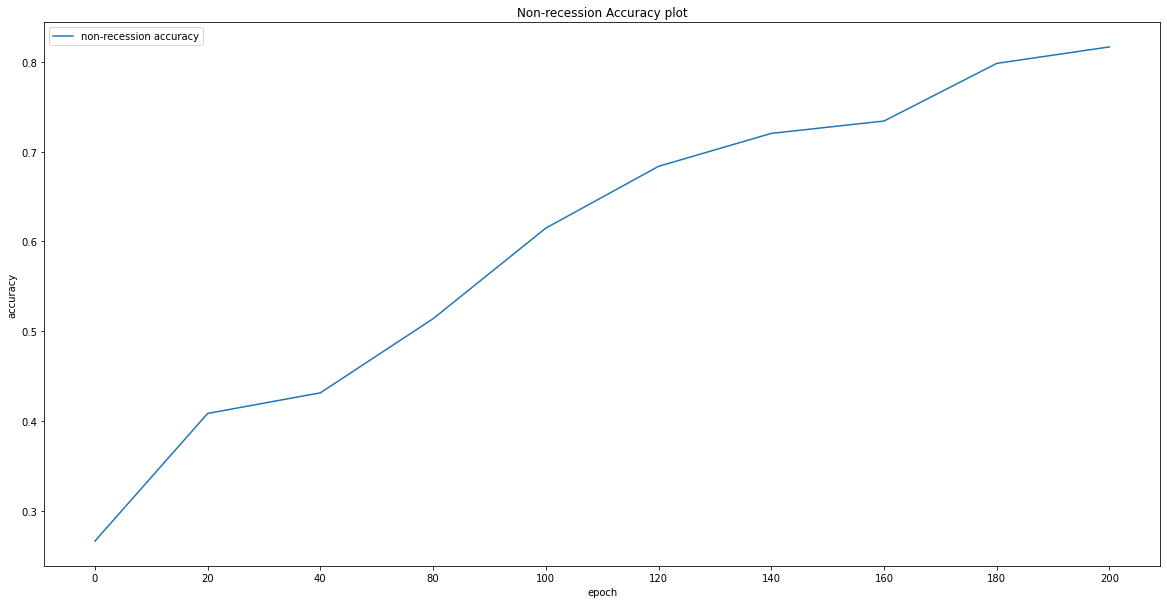

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

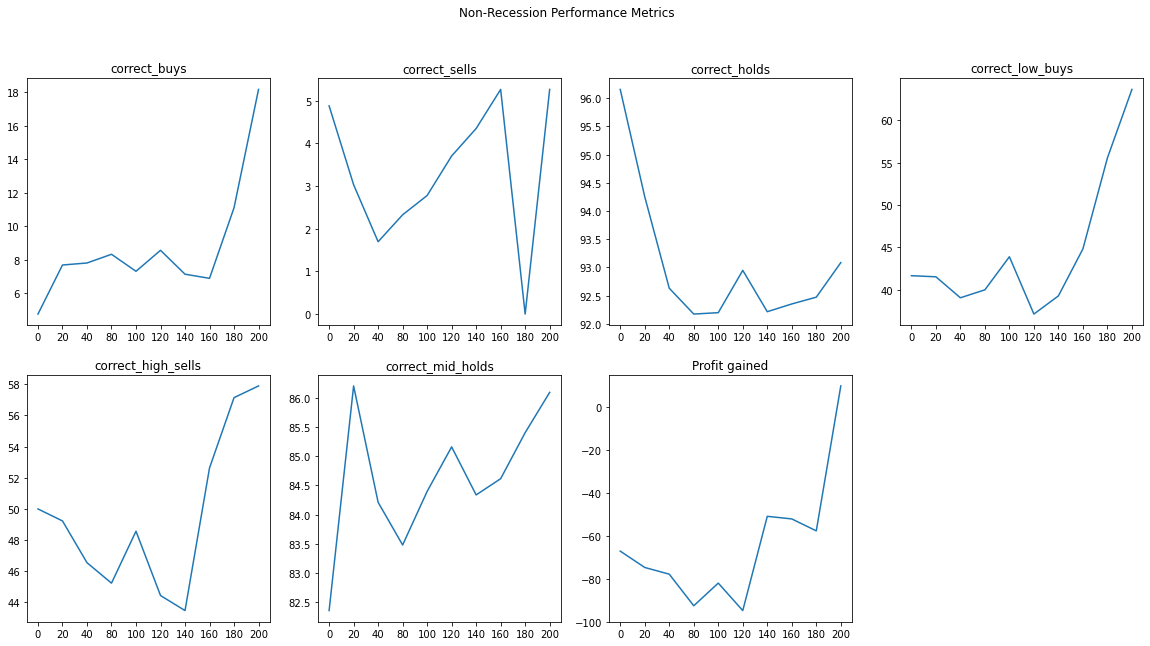

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(nr_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(nr_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(nr_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(nr_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(nr_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(nr_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(nr_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")

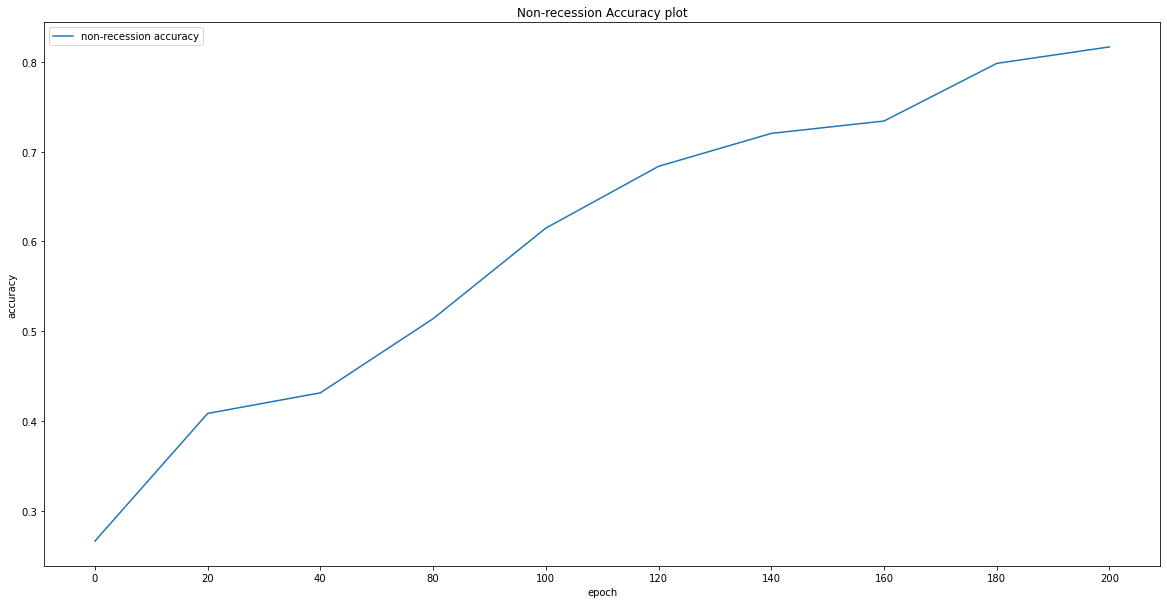

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(nr_log_hist['epochs_logs']['Test_accuracy'].values)
plt.title('Non-recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['non-recession accuracy'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Profit gained')

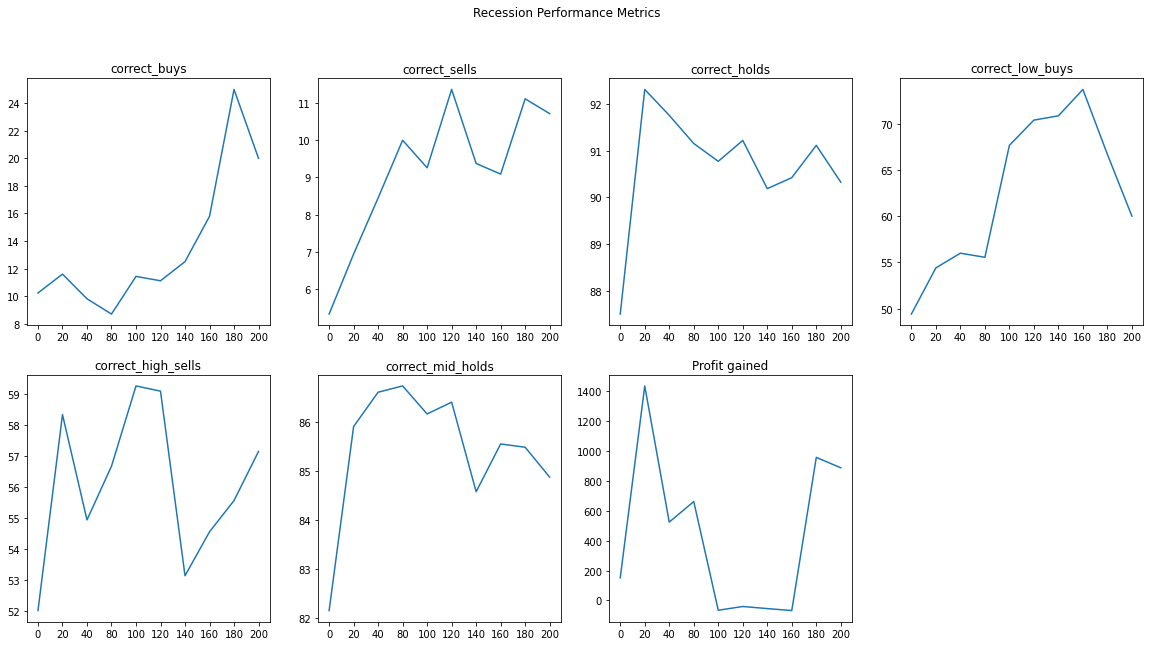

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Performance Metrics")

plt.subplot(2, 4, 1)
plt.plot(r_log_hist['epochs_logs']['correct_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_buys")

plt.subplot(2, 4, 2)
plt.plot(r_log_hist['epochs_logs']['correct_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_sells")

plt.subplot(2, 4, 3)
plt.plot(r_log_hist['epochs_logs']['correct_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_holds")

plt.subplot(2, 4, 4)
plt.plot(r_log_hist['epochs_logs']['correct_low_buys'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_low_buys")

plt.subplot(2, 4, 5)
plt.plot(r_log_hist['epochs_logs']['correct_high_sells'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_high_sells")

plt.subplot(2, 4, 6)
plt.plot(r_log_hist['epochs_logs']['correct_mid_holds'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("correct_mid_holds")

plt.subplot(2, 4, 7)
plt.plot(r_log_hist['epochs_logs']['Profit gained'].values)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("Profit gained")